# CAUSAL HMM 

This notebook contains the code snippets for the model presented in the paper "Causal AI For Interpretable Cyber Early Warning Systems"

This paper follows our previous work presented in : https://www.icsc-conference.org/2024/papers/7582.pdf

### 1. DATA PREPARATION 

First code section contains data preparation elements

In [2]:
# If necessary, install libs
#!pip install pandas matplotlib scikit-learn seaborn scipy openpyxl shap

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore') 
import random
from pandas.testing import assert_frame_equal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import shap

In [30]:
df = pd.read_csv("datasets/dataset_anonymized.csv")
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X39,X40,X41,X42,X43,X44,Y,Z1,Z2,Z3
0,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-0.427323,-0.450457,0.362949,-1.0,-1.0,0.0,1.0,0.0,0.0
1,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,-1.000000,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
2,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
3,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
4,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-0.446662,-0.248958,...,0.032951,0.145353,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0


### Data description

$X_0 \dots X_{44}$ : Signals (observed)

$Y$ : Target (incident at h+1)

$Z_1 \dots Z_3$ : Latent state vector elements (from HMM)

$i$ : hours

### 2. CLASSIFIER

This code sections retrains the classifier based on signals and latent states, as shown in the first paper implementation

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  

In [32]:
# data sample
X = df.drop(['Y'],axis=1).values
y = df['Y'].astype(int).values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

#train
mlp = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
mlp.fit(X_train, y_train)

# predict
mlp_y_pred = mlp.predict(X_test)

# scores
print()
print(f'F1        : {metrics.f1_score(y_test, mlp_y_pred)}')
print(f'Accuracy  : {metrics.accuracy_score(y_test, mlp_y_pred)}')
print(f'Precision : {metrics.precision_score(y_test, mlp_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test, mlp_y_pred)}')


F1        : 0.8571428571428572
Accuracy  : 0.8833333333333333
Precision : 0.863013698630137
ROC-AUC   : 0.878505864354921


In [33]:
# Compare randomized 

sdf = df.copy()


tdf = list(sdf['X11'])
i = 1
while i < 1000:
    random.shuffle(tdf)
    i+=1
sdf['X37'] = tdf

# Check false - we randomized effectively
if df.equals(sdf) == False:
    print(f'[+] Finished!\n')

# test
X = sdf.drop(['Y'],axis=1).values
y = sdf['Y'].astype(int).values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

y_pred = mlp.predict(X_test)

# scores
print(f'F1        : {metrics.f1_score(y_test, y_pred)}')
print(f'Accuracy  : {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision : {metrics.precision_score(y_test, y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test, y_pred)}')

print(f'\n[!] We can observe the performance decreases when perturbing signals...')

[+] Finished!

F1        : 0.7724137931034482
Accuracy  : 0.8166666666666667
Precision : 0.7887323943661971
ROC-AUC   : 0.8076236613972464

[!] We can observe the performance decreases when perturbing signals...


### 3. L2 CAUSAL INFERENCE

Next sections contains the code to compute interventional distribution of $P(Y|do(X=x))$, i.e. fixing $X$ using Structural Causal Model (SCM) and Do Calculus. 

Do-calculus can be used to control $X$ if the SCM satisfies Back-door criterion of Front-door criterion. 

We will use Back-door criterion as given by: 

> SCM = (z->y),(z->x),(x->y)
>
> Sufficient Set = $\{Z_i\}$
>
> Condition 1. No node in $\{Z_i\}$ ($=Z$) is a descendant of $X$
>
> Condition 2. All node of $\{Z_i\}$ block back-door paths (X->Y) (fork on x<-Z->y)
>
> Therefore, we can estimate interventional distribution $P(Y|do(X=x)$ using TFF, s.t.
>
> $P(Y|do(X=x) = \sum_{i}^{}P(Y|x,Z_i)P(Z_i)$


This distribution answers the question : "Is it alert $X$ that caused $Y$ ?"

In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

In [35]:
# vectorize
adf = pd.DataFrame()

# assign SCM values
x = list(df.iloc[:, 0:45].columns)
z = list(df.iloc[:, 46:49].columns)

# insert
adf['X'] = df[x].values.tolist()
adf['Z'] = df[z].values.tolist()
adf['Y'] = df['Y'].astype(int).values

# check
adf.head()

,X,Z,Y
0,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
1,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
2,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
3,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
4,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0


Now, we compute  $P(Y|do(X=x) = \sum_{i}^{}P(Y|x,Z_i)P(Z_i)$

In [36]:
# setup
X = np.stack(adf['X'].values) 
Z = np.stack(adf['Z'].values) 
Y = adf['Y'].values 

# Utils for P(Y|x,z)
model = LogisticRegression(random_state=42)
model.fit(np.hstack((X, Z)), Y, )

# Utils for P(Y|do(X=x))
def compute_do_prob(x_val, df, model):
    Z = np.stack(df['Z'].values) 
    X_z_combined = np.hstack((np.repeat([x_val], len(Z), axis=0), Z))
    P_Y_given_x_Z = model.predict_proba(X_z_combined)[:, 1]
    unique_Z, counts = np.unique(Z, axis=0, return_counts=True)
    P_Z = counts / len(Z)  
    P_Y_do_x = np.sum([P_Y_given_x_Z[i] * P_Z[i] for i in range(len(P_Z))])
    return P_Y_do_x

# create identify matrix for each signal such that X(target)=x and X(non-target)=0 
signals_id = np.identity(45)
signals_id = pd.DataFrame(signals_id)
signals_id.columns = x
signals_id.index = x

In [37]:
# Compute P(Y|do(X=x))
doxl = []

for index, row in signals_id.iterrows():
    x_val = np.array(row)
    P_Y_do_x = compute_do_prob(x_val, adf, model)
    doxl.append(P_Y_do_x)

doXdf = pd.DataFrame()
doXdf['X'] = x
doXdf['doX'] = doxl
doXdf.head()

,X,doX
0,X0,0.944721
1,X1,0.900621
2,X2,0.831875
3,X3,0.566240
4,X4,0.496654


In [38]:
# compute standard-error & confidence interval .95

lci1 = []
lci2 = []

for x in list(df.columns)[:-4] : 
    se = df[[x]].std() / np.sqrt(len(df[x]))
    mu = df[[x]].mean()
    ci1 = mu - 2 * se
    ci2 = mu + 2 * se
    lci1.append(ci1[0])
    lci2.append(ci2[0])

doXdf['Ci1'] = lci1
doXdf['Ci2'] = lci2

l = []
u = []

for index, row in doXdf.iterrows():

    d = row['doX']
    low = row['doX'] + row['Ci1']
    upp = row['doX'] + row['Ci2']

    l.append(low)
    u.append(upp)

doXdf['Ci1'] = l
doXdf['Ci2'] = u
doXdf.head()

,X,doX,Ci1,Ci2
0,X0,0.944721,0.935409,0.953990
1,X1,0.900621,0.886206,0.915133
2,X2,0.831875,0.808044,0.855426
3,X3,0.566240,0.560838,0.571616
4,X4,0.496654,0.468634,0.524288


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

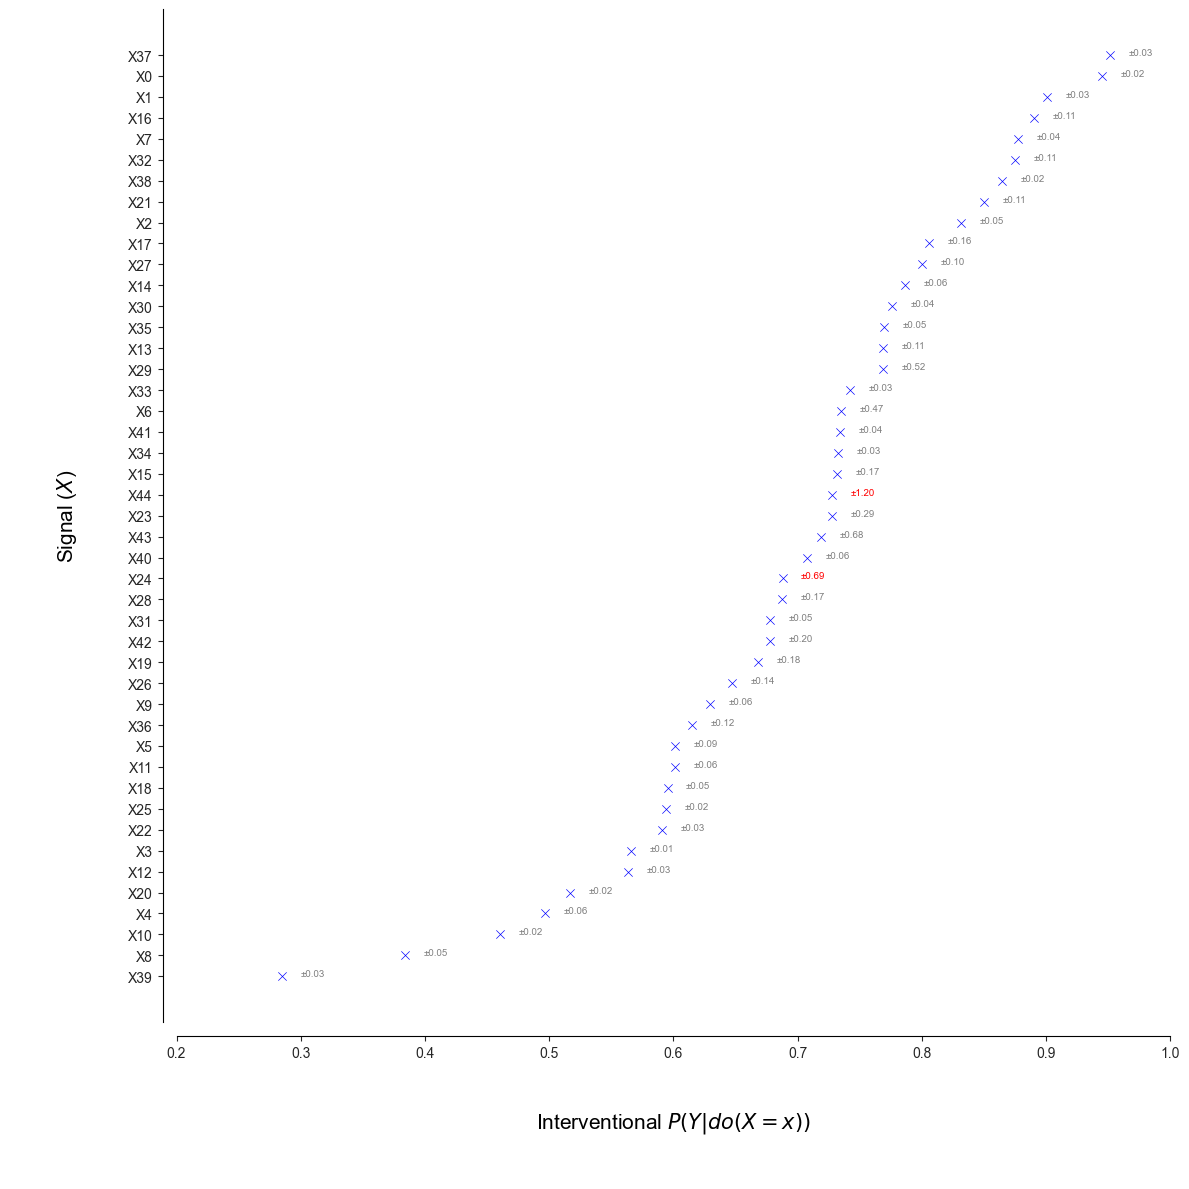

In [40]:
# Plot the DoX and CI values 
plt.figure(figsize=(12, 12))

# sort for better read
sorted_df = doXdf.sort_values(by=['doX'], ascending=False)

# plot values
g = sns.scatterplot(data=sorted_df, x="doX", y="X", marker='x', alpha=1, color='blue')

# plot error range
for idx, row in doXdf.iterrows():
    error_value = row['Ci2'] - row['Ci1']
    if error_value >= row['doX']*0.95:
        c='red'
    else:
        c='grey'
    plt.text(row['doX'] + 0.015, row['X'], f'±{error_value:.2f}', fontsize=7, color=c)

# setup ax labels and title

sns.set_style("ticks")
sns.despine(top=True, right=True, offset=10)
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\nInterventional $P(Y|do(X=x))$\n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0.2, 1, num=9))

#sns.despine(bottom=True, left=True)
#save plot
plt.draw()
#plt.savefig('Figures/FIG1_PYDOX_TXTERR.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [41]:
from sklearn import preprocessing

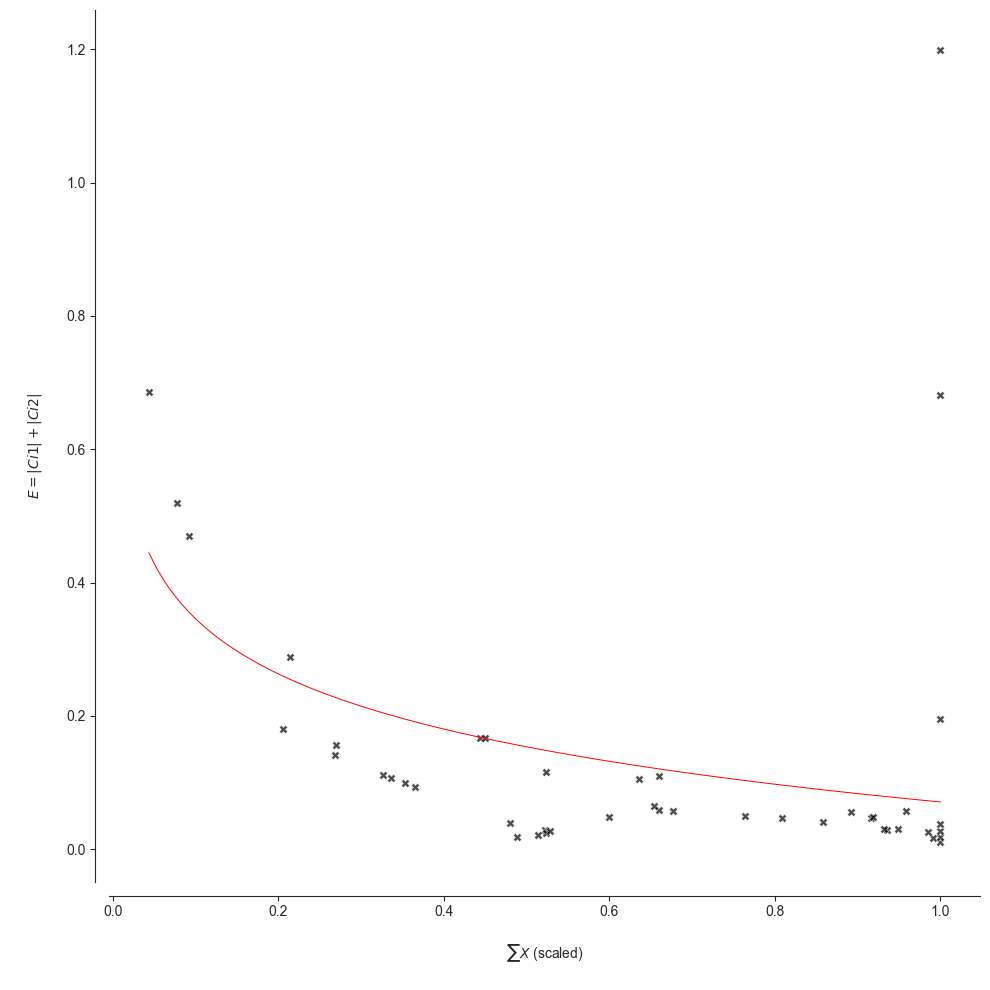

In [42]:
# same plot, but plot on one axis the span of Ci1-Ci2 and on the other the volum of this event
# Useful to better understand the really high error rates on some signals

# 0. Recover data
df2 = pd.read_csv("datasets/h_numeric_anonymized.csv")

# 1. compute sum of each column from df
v = []

for col in df2.columns[:-4]:
    v.append(df2[col].sum())

for i in range(len(v)):
    v[i] = (v[i]-min(v))/(max(v)-min(v))


# 2. compute range or error
e = []

for i in range(len(lci1)):
    e_ = abs(lci1[i])+abs(lci2[i])
    e.append(e_)

# 3. Create df
pl2 = pd.DataFrame()
pl2['X'] = doXdf['X']
pl2['V'] = v
pl2['E'] = e

# 4. plot df
plt.figure(figsize=(10,10))

# data points
g = sns.scatterplot(data=pl2, x="V", y="E", marker='X', alpha=.7, color='black')

# log regression line
pl2['log_V'] = np.log(pl2['V'] + 1e-10)
m, b = np.polyfit(pl2['log_V'], pl2['E'], 1)
x_values = np.linspace(pl2['V'].min(), pl2['V'].max(), 100)
log_x_values = np.log(x_values + 1e-10)
y_values = m * log_x_values + b

plt.plot(x_values, y_values, color='red', linewidth=.7)

# style
sns.set_style("ticks")
sns.despine(top=True, right=True, offset=10)
g.set_xlabel('\n$\sum X$ (scaled)\n')
g.set_ylabel('\n$E = |Ci1|+|Ci2|$\n')

#plt.draw()
#plt.savefig('Figures/FIG2_FREQ_ERROR_PYDOX.jpeg', dpi=400, bbox_inches='tight')
plt.tight_layout()
plt.show()

### 4. L3 CAUSAL INFERENCE

## Method 1. Using TFF

Next sections contains the code to compute conterfactual distribution $P(Y_{do(X=x)} = y | X , Y)$, by using meta learners. 

Given the structural causal model, the distribution is given by : $P(Y_{do(X=1) = 1} | X = 0, Y = 0) = \frac{P(Y_{X=1}=1,X=0,Y=0)}{P(X=0,Y=0)}$

This distribution answers the question : "Would have $Y$ been different if we had $X_0$ instead of $X_1$ ?"

In [43]:
# 1. Compute P(X=0, Y=0) for each X
P_X0_Y0 = []

for x in list(df2.columns[:-4]):
    c = 0
    l = 0
    for index, row in df2.iterrows():
        if row[x] == 0 and row['Y'] == 0:
            c += 1
        if row['Y'] == 0:
            l += 1
    P_X0_Y0.append(c/l)

doXdf['P_X0_Y0'] = P_X0_Y0

# 2. Compute numerator for non 0 relative denominator
l3 = []
for index, row in doXdf.iterrows():
    if row['P_X0_Y0'] > 0 :
        i = row['doX'] * row['P_X0_Y0']
    else:
        i = 0
    l3.append(i)

doXdf['P_Y1_DX1'] = l3
doXdf.head()

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1
0,X0,0.944721,0.935409,0.953990,0.026961,0.025470
1,X1,0.900621,0.886206,0.915133,0.000000,0.000000
2,X2,0.831875,0.808044,0.855426,0.080882,0.067284
3,X3,0.566240,0.560838,0.571616,0.000000,0.000000
4,X4,0.496654,0.468634,0.524288,0.068627,0.034084


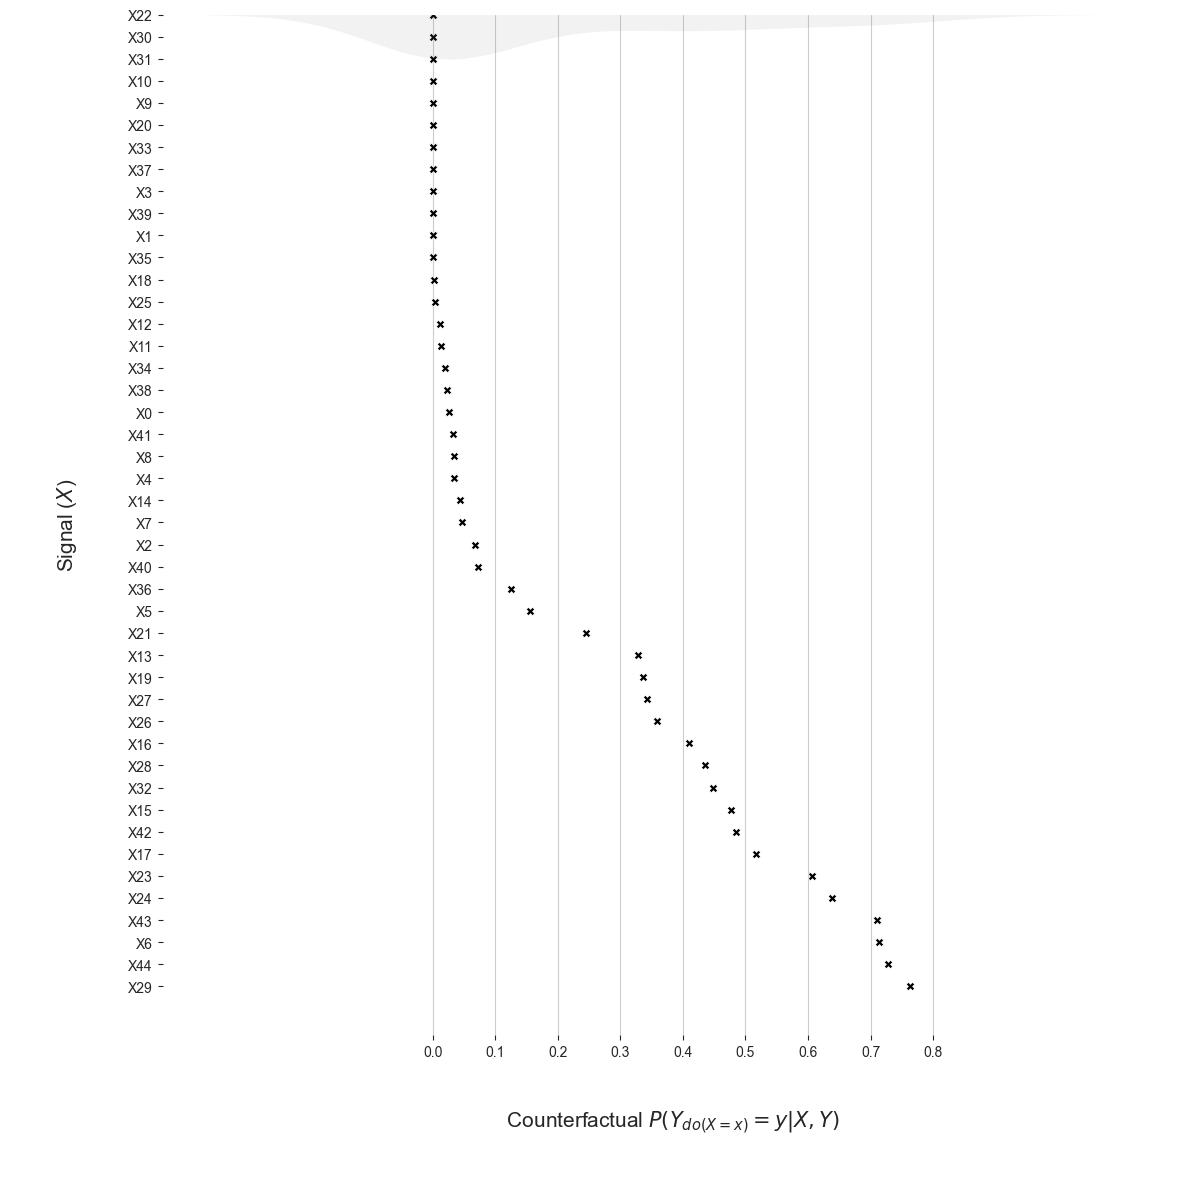

In [44]:
plt.figure(figsize=(12, 12))
plt.grid(axis='x')

# sort for better read
sorted_df = doXdf.sort_values(by=['P_Y1_DX1'], ascending=True)

# plot values
sns.scatterplot(data=sorted_df, y='X', x='P_Y1_DX1', color='black', marker='X', zorder=1) 

sns.kdeplot(data=doXdf['P_Y1_DX1'], 
            color='grey', 
            linewidth=0, 
            alpha=0.1, 
            fill=True,
            zorder=2)

# setup ax labels and title
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\n Counterfactual $P(Y_{do(X=x)} = y | X , Y)$ \n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0, 0.8, num=9))
plt.yticks(size=10)
sns.despine(bottom=True, left=True)

#save plot
plt.draw()
#plt.savefig('Figures/FIG3_PYYDOXX_COUNTERFACTUAL.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Method 2. Using Meta Learners

> Source : https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

### S-Learner : single model

> Train model on (X,Y,Z, T), s.t. we obtain $\hat{f}(X,Z,T) = E\{Y|X,Z,T\}$
>
> Where $Z$ represents $\langle Z_1, Z_2, Z_3\rangle$, $X$ the signals, $T$ the treatment, $Y$ the outcome
>
> When model is trained, compute:
>
> $ITE_i = \hat{f}(X_i = 1, Z_i) - \hat{f}(X_i = 0, Z_i)$
>
> Finally, compute $ATE_T = \frac{1}{N}\sum ITE_i$

In [45]:
# Compute ATE for each signal

test = df.sample(frac=0.3, random_state=42)
train = df.loc[~df.index.isin(test.index)]

X = list(df.columns[:45])+list(df.columns[-3:]) 
y = 'Y'

# S-Learners
s_learner_rf = RandomForestClassifier(n_estimators = 100, random_state=42) 
s_learner_rf.fit(train[X], train[y])

s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
s_learner_dnn.fit(train[X], train[y])

# T-Learners

m0_rf = RandomForestClassifier(n_estimators = 100)  
m1_rf = RandomForestClassifier(n_estimators = 100)

m0_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

# ATE lists

rf_ATE_s = []
dnn_ATE_s = []
rf_ATE_t = []
dnn_ATE_t = []

for index_a, row_a in doXdf.iterrows():

    tl = []
    T =  row_a['X']

    m0_rf.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
    m1_rf.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))
    
    m0_dnn.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
    m1_dnn.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))
    
    # Switch treatments
    for index, row in df.iterrows():
        if row[T] < 0 :
            tl.append(1)
        else:
            tl.append(0)
    
    xi_0 = df.copy()
    xi_1 = df.copy()
    xi_1[T] = tl
    
    # Compute ITE
    rf_f_x0 = s_learner_rf.predict(xi_0[X])
    rf_f_x1 = s_learner_rf.predict(xi_1[X])

    dnn_f_x0 = s_learner_dnn.predict(xi_0[X])
    dnn_f_x1 = s_learner_dnn.predict(xi_1[X])
    
    rf_ITE = []
    dnn_ITE = []
    
    for i in range(len(rf_f_x1)):
        rf_ITE.append(rf_f_x1[i]-rf_f_x0[i])

    for i in range(len(dnn_f_x1)):
        dnn_ITE.append(dnn_f_x1[i]-dnn_f_x0[i])
    
    
    # Compute ATE SL
    rf_ATE = (sum(rf_ITE)/len(rf_ITE))
    rf_ATE_s.append(rf_ATE)
    dnn_ATE = (sum(dnn_ITE)/len(dnn_ITE))
    dnn_ATE_s.append(dnn_ATE)

    # Compute ATE TL
    rf_t_learner_cate_train = m1_rf.predict(df[X]) - m0_rf.predict(df[X])
    dnn_t_learner_cate_train = m1_dnn.predict(df[X]) - m0_dnn.predict(df[X])
    
    rf_ATE = sum(rf_t_learner_cate_train)/len(rf_t_learner_cate_train)
    dnn_ATE = sum(dnn_t_learner_cate_train)/len(dnn_t_learner_cate_train)

    rf_ATE_t.append(rf_ATE)
    dnn_ATE_t.append(dnn_ATE)


doXdf['SL_RF_ATE'] = rf_ATE_s   
doXdf['SL_DNN_ATE'] = dnn_ATE_s  
doXdf['TL_RF_ATE'] = rf_ATE_t   
doXdf['TL_DNN_ATE'] = dnn_ATE_t  

In [46]:
doXdf.sort_values('SL_DNN_ATE', ascending=True).head()

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1,SL_RF_ATE,SL_DNN_ATE,TL_RF_ATE,TL_DNN_ATE
9,X9,0.629653,0.601247,0.658750,0.000000,0.000000,-0.016667,-0.109722,-0.152778,-0.031944
10,X10,0.460781,0.448365,0.473280,0.000000,0.000000,-0.002778,-0.041667,0.226389,0.283333
35,X35,0.769893,0.744652,0.793210,0.000000,0.000000,-0.011111,-0.034722,-0.234722,-0.119444
20,X20,0.516966,0.508712,0.525151,0.000000,0.000000,-0.001389,-0.029167,-0.566667,-0.408333
28,X28,0.687462,0.605108,0.772593,0.632353,0.434718,-0.001389,-0.023611,-0.204167,-0.100000


In [31]:
#doXdf.to_csv('Exports/ATE_SLEARNER_TLEARNER_RF_DNN.csv', index=False)

In [32]:
# Define elasticity & cumulative gain funcs
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

## S-learner

In [11]:
# Sample test/train 
signal = 'X17' # X29, X42, X28
test = df.sample(frac=0.2, random_state=42)
train = df.loc[~df.index.isin(test.index)]

# retrieve features without Y
X = list(df.columns[:45])+list(df.columns[-3:]) #-4
y = 'Y'
T = signal

# arch 1
s_learner = RandomForestClassifier(n_estimators = 100, random_state=42) 
s_learner.fit(train[X], train[y])

# arch 2
s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
s_learner_dnn.fit(train[X], train[y])

# Copy df for measure case Xi = 0 and Xi = 1
tl = []

for index, row in df.iterrows():
    # Create new column with inverse treatment as real ones
    if row[T] < 0 : # -1:
        tl.append(1)
    else:
        tl.append(0)

xi_0 = df.copy()
xi_1 = df.copy()
xi_1[T] = tl

# Compute ITE
rf_f_x0 = s_learner.predict(xi_0[X])
rf_f_x1 = s_learner.predict(xi_1[X])
rf_ITE = []

dnn_f_x0 = s_learner.predict(xi_0[X])
dnn_f_x1 = s_learner.predict(xi_1[X])
dnn_ITE = []

for i in range(len(rf_f_x1)):
    rf_ITE.append(rf_f_x1[i]-rf_f_x0[i])

for i in range(len(dnn_f_x1)):
    dnn_ITE.append(dnn_f_x1[i]-dnn_f_x0[i])

# Compute ATE for T
rf_ATE = sum(rf_ITE)/len(rf_ITE)
dnn_ATE = sum(dnn_ITE)/len(dnn_ITE)
ATE= (rf_ATE+dnn_ATE)/2     

# Estimate CATE by combining ITE models 

# with RF

rf_s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) - 
                        s_learner.predict(train[X].assign(**{T: 0})))

rf_s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

# With DNN

dnn_s_learner_cate_train = (s_learner_dnn.predict(train[X].assign(**{T: 1})) - 
                        s_learner_dnn.predict(train[X].assign(**{T: 0})))

dnn_s_learner_cate_test = test.assign(
    cate=(s_learner_dnn.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner_dnn.predict(test[X].assign(**{T: 0}))) # predict under control
)

# Cumulative Gain curves
# These plots are only useful to verify that we are not overfitting

rf_gain_curve_test = cumulative_gain(rf_s_learner_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_s_learner_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_s_learner_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_s_learner_cate_train), "cate", y="Y", t=T)

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", f'{signal}')], linewidth=1, linestyle="dotted", color="black", label="Baseline")
plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nS-learner"+r' $\mathcal{M}_{sl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{sl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)
plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.draw()
plt.box(False)
#plt.savefig('Figures/FIG4_SLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## T-Learner 

> Models learn: $\mu_0(x) = E[Y|T=0,X]$, $\mu_1(x) = E[Y|T=1,X]$
>
> Then we infer : $\hat{\gamma}(X_i) = M_1(x_i) - M_0(X_i)$

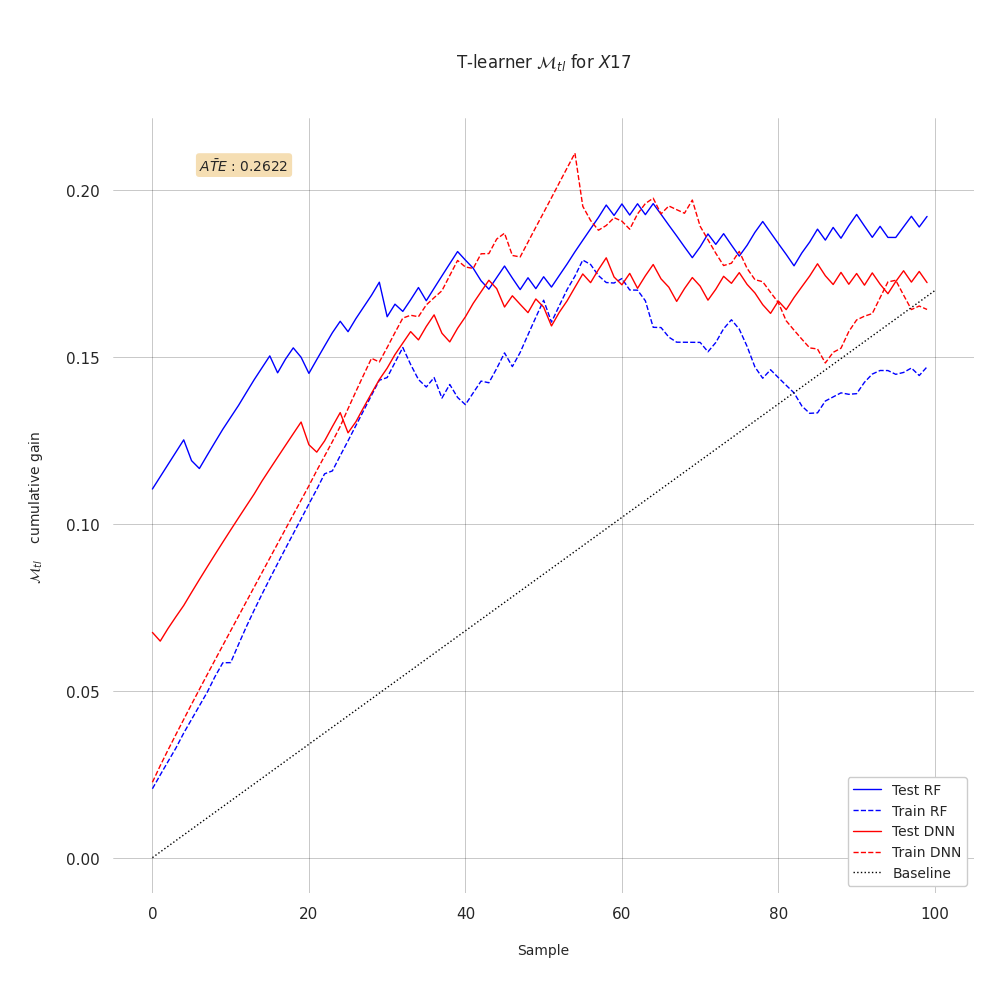

In [152]:
# setup bimodel & fit
m0_rf = RandomForestClassifier(n_estimators = 100)  
m1_rf = RandomForestClassifier(n_estimators = 100)

m0_rf.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
m1_rf.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))

m0_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

m0_dnn.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
m1_dnn.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))

# predictions
rf_t_learner_cate_train = m1_rf.predict(train[X]) - m0_rf.predict(train[X])
rf_t_learner_cate_test = test.assign(cate=m1_rf.predict(test[X]) - m0_rf.predict(test[X]))

dnn_t_learner_cate_train = m1_dnn.predict(train[X]) - m0_dnn.predict(train[X])
dnn_t_learner_cate_test = test.assign(cate=m1_dnn.predict(test[X]) - m0_dnn.predict(test[X]))

# ATE
rf_ATE = sum(rf_t_learner_cate_train)/len(rf_t_learner_cate_train)
dnn_ATE = sum(dnn_t_learner_cate_train)/len(dnn_t_learner_cate_train)
ATE = (dnn_ATE+rf_ATE)/2

# Cumulative gain curves

rf_gain_curve_test = cumulative_gain(rf_t_learner_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_t_learner_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_t_learner_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_t_learner_cate_train), "cate", y="Y", t=T)

# plot

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", T)], linewidth=1, linestyle="dotted", color="black", label="Baseline")
plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nT-learner"+r' $\mathcal{M}_{tl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{tl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
plt.draw()
plt.box(False)

plt.savefig('Figures/FIG5_TLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

### X-Learner

Stage 1.

> $\hat{M}_0(X) = E[Y|T=0, X]$
>
> $\hat{M}_1(X) = E[Y|T=1, X]$
>

Stage 2.

> $\hat{\gamma}(X,T=0) = \hat{M}_1(X,T=0)-Y_{T=0}$
>
> $\hat{\gamma}(X,T=1) = Y_{T=1} - \hat{M}_0(X,T=1)$
>

Stage 3.

> $\hat{M}_{\gamma 0}(X) = E[\hat{\gamma}(X)|T=0]$
>
> $\hat{M}_{\gamma 1}(X) = E[\hat{\gamma}(X)|T=1]$

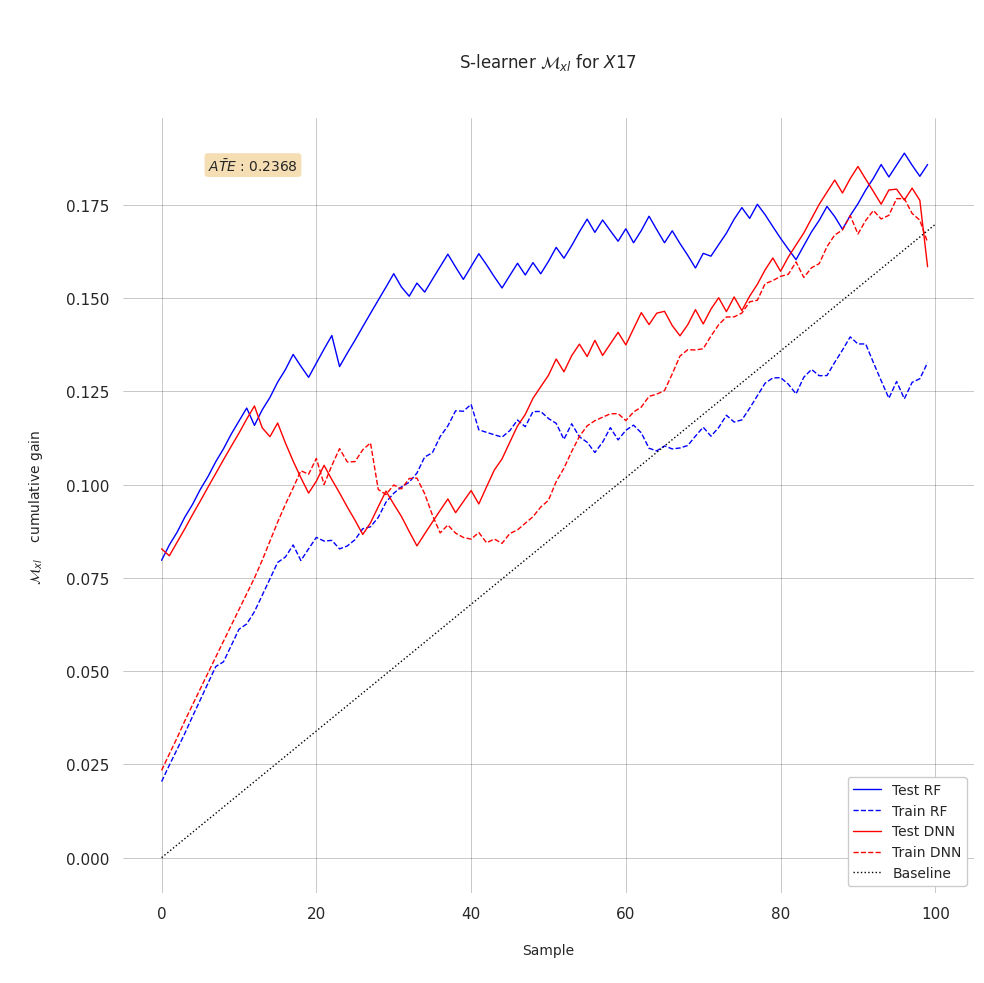

In [154]:
# Stage 1. bimodel setup & fit f(z) and g(z)

m0_rf_xl = RandomForestClassifier(n_estimators = 100)  
m1_rf_xl = RandomForestClassifier(n_estimators = 100)
m0_rf_xl.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))     # g(z)
m1_rf_xl.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))   # f(z)

m0_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m0_dnn_xl.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))     # g(z)
m1_dnn_xl.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))   # f(z)

# Logistic regression as propensity score model

g = LogisticRegression(solver="lbfgs") 
g.fit(train[X], train[y].astype(int));

# Double training function util

d_train_rf = np.where(train[T]<0, m1_rf_xl.predict(train[X]) - train[y],    # D0  = f(z) - Yi
                   train[y] - m0_rf_xl.predict(train[X]))                   # D1  = Yi - G(z)

d_train_dnn = np.where(train[T]<0, m1_dnn_xl.predict(train[X]) - train[y],    # D0  = f(z) - Yi
                   train[y] - m0_dnn_xl.predict(train[X]))                   # D1  = Yi - G(z)

# Stage 2. bimodel setup & fit ITE

mx0_rf_xl = RandomForestClassifier(n_estimators = 100) # T0(z)
mx1_rf_xl = RandomForestClassifier(n_estimators = 100) # T1(z)

mx0_rf_xl.fit(train.query(f"{T}<0")[X], d_train_rf[train[T]<0]) 
mx1_rf_xl.fit(train.query(f"{T}>=0")[X], d_train_rf[train[T]>=0])

mx0_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
mx1_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

mx0_dnn_xl.fit(train.query(f"{T}<0")[X], d_train_dnn[train[T]<0]) 
mx1_dnn_xl.fit(train.query(f"{T}>=0")[X], d_train_dnn[train[T]>=0])

# Stage 3. Estimate CATE

def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
rf_x_cate_train = (ps_predict(train,1)*mx0_rf_xl.predict(train[X]) +
                ps_predict(train,0)*mx1_rf_xl.predict(train[X]))

rf_x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0_rf_xl.predict(test[X]) +
                                ps_predict(test,0)*mx1_rf_xl.predict(test[X])))

dnn_x_cate_train = (ps_predict(train,1)*mx0_dnn_xl.predict(train[X]) +
                ps_predict(train,0)*mx1_dnn_xl.predict(train[X]))

dnn_x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0_dnn_xl.predict(test[X]) +
                                ps_predict(test,0)*mx1_dnn_xl.predict(test[X])))


# CATE
rf_ATE = sum(rf_x_cate_train)/len(rf_x_cate_train)
dnn_ATE = sum(dnn_x_cate_train)/len(dnn_x_cate_train)
ATE = (dnn_ATE+rf_ATE)/2

# Cumulative gains

rf_gain_curve_test = cumulative_gain(rf_x_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_x_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_x_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_x_cate_train), "cate", y="Y", t=T)

# Plot

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", T)], linewidth=1, linestyle="dotted", color="black", label="Baseline")

plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nS-learner"+r' $\mathcal{M}_{xl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{xl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
plt.draw()
plt.box(False)

plt.savefig('Figures/FIG6_XLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()

# PART III - EXPLAINABILITY WITH SHAP

In [33]:
import shap

### S-Learn

In [156]:
# Explain S-Learner for RF & DNN

# 1. Fit the explainer
sl_rf_explainer = shap.Explainer(s_learner.predict, test[X])
sl_dnn_explainer = shap.Explainer(s_learner_dnn.predict, test[X])

# 2. Compute SHAP values
sl_rf_shap_values = sl_rf_explainer(test[X])
sl_dnn_shap_values = sl_dnn_explainer(test[X])

PermutationExplainer explainer: 145it [00:11,  1.84it/s]                                                                      


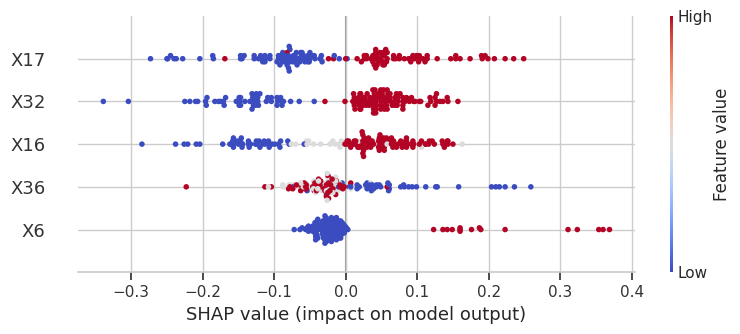

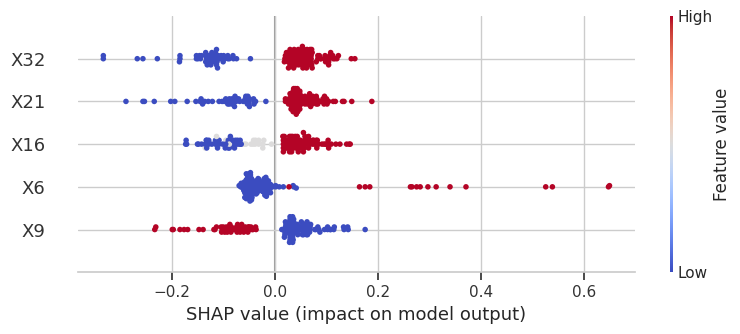

<Figure size 640x480 with 0 Axes>

In [159]:
# 3. Plot values for S-Learn RF

shap.summary_plot(sl_rf_shap_values, cmap='coolwarm', max_display=5)
plt.savefig('Figures/FIG7_SHAP_SLEARN_RF_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)
#shap.plots.bar(sl_rf_shap_values)

# 3. Plot values for S-Learn DNN

shap.summary_plot(sl_dnn_shap_values, cmap='coolwarm', max_display=5)
plt.savefig('Figures/FIG7_SHAP_SLEARN_DNN_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(sl_dnn_shap_values)

### T-Learn

In [160]:
# Explain T-Learner for RF & DNN

# 1. Fit the explainer 

# RF bimodel
tl_rf_m0_explainer = shap.Explainer(m0_rf.predict, test[X])
tl_rf_m1_explainer = shap.Explainer(m1_rf.predict, test[X])

# DNN Bimodel
tl_dnn_m0_explainer = shap.Explainer(m0_dnn.predict, test[X])
tl_dnn_m1_explainer = shap.Explainer(m1_dnn.predict, test[X])

# 2. Compute SHAP values
tl_rf_m0_shap_values = tl_rf_m0_explainer(test[X])
tl_rf_m1_shap_values = tl_rf_m1_explainer(test[X])

tl_dnn_m0_shap_values = tl_dnn_m0_explainer(test[X])
tl_dnn_m1_shap_values = tl_dnn_m1_explainer(test[X])

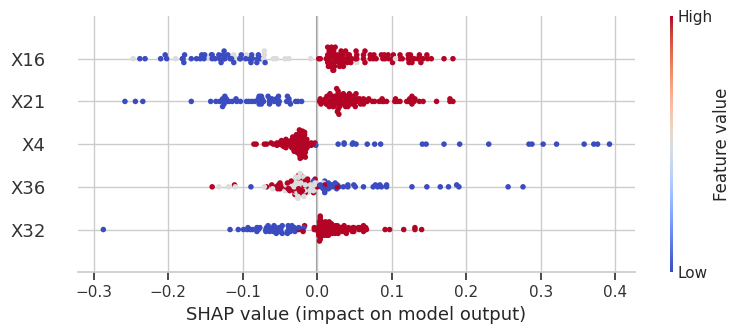

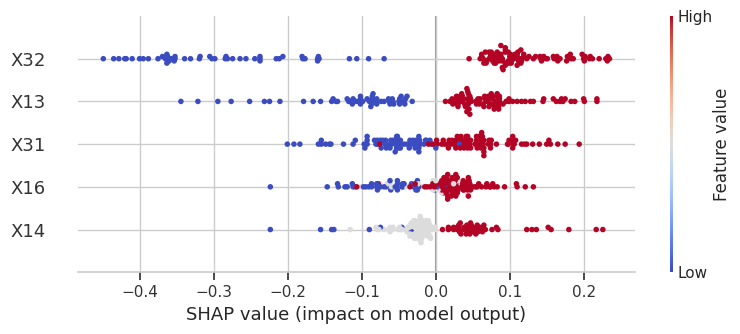

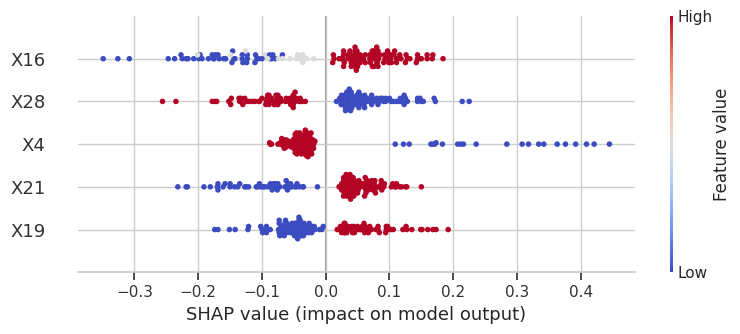

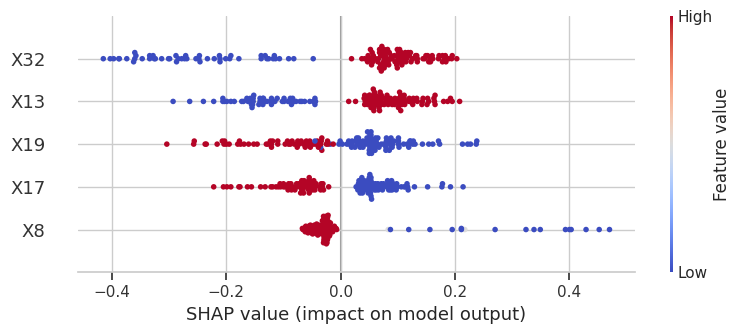

<Figure size 640x480 with 0 Axes>

In [161]:
# 3. Plot values for T-Learn RF

shap.summary_plot(tl_rf_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG9_SHAP_TLEARN_RFM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_rf_m0_shap_values)

shap.summary_plot(tl_rf_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG10_SHAP_TLEARN_RFM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_rf_m1_shap_values)

# 3. Plot values for T-Learn DNN

shap.summary_plot(tl_dnn_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG11_SHAP_TLEARN_DNNM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_dnn_m0_shap_values)

shap.summary_plot(tl_dnn_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG12_SHAP_TLEARN_DNNM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_dnn_m1_shap_values)

### X-Learn

In [162]:
# Explain X-Learner for RF & DNN

# 1. Fit the explainer 

# RF Quadmodel
xl_rf_m0_explainer = shap.Explainer(m0_rf_xl.predict, test[X])
xl_rf_m1_explainer = shap.Explainer(m1_rf_xl.predict, test[X])
xl_rf_mx0_explainer = shap.Explainer(mx0_rf_xl.predict, test[X])
xl_rf_mx1_explainer = shap.Explainer(mx1_rf_xl.predict, test[X])

# DNN Quadmodel
xl_dnn_m0_explainer = shap.Explainer(m0_dnn_xl.predict, test[X])
xl_dnn_m1_explainer = shap.Explainer(m1_dnn_xl.predict, test[X])
xl_dnn_mx0_explainer = shap.Explainer(mx0_dnn_xl.predict, test[X])
xl_dnn_mx1_explainer = shap.Explainer(mx1_dnn_xl.predict, test[X])

# 2. Compute SHAP values
xl_rf_m0_shap_values = xl_rf_m0_explainer(test[X])
xl_rf_m1_shap_values = xl_rf_m1_explainer(test[X])
xl_rf_mx0_shap_values = xl_rf_mx0_explainer(test[X])
xl_rf_mx1_shap_values = xl_rf_mx1_explainer(test[X])

xl_dnn_m0_shap_values = xl_dnn_m0_explainer(test[X])
xl_dnn_m1_shap_values = xl_dnn_m1_explainer(test[X])
xl_dnn_mx0_shap_values = xl_dnn_mx0_explainer(test[X])
xl_dnn_mx1_shap_values = xl_dnn_mx1_explainer(test[X])

In [ ]:
# 3. Plot values for X-Learn RF

shap.summary_plot(xl_rf_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG13_SHAP_XLEARN_RFM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_m0_shap_values)
shap.summary_plot(xl_rf_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG14_SHAP_XLEARN_RFM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_m1_shap_values)
shap.summary_plot(xl_rf_mx0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG15_SHAP_XLEARN_RFMX0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_mx0_shap_values)
shap.summary_plot(xl_rf_mx1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG16_SHAP_XLEARN_RFMX1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_mx1_shap_values)

# 3. Plot values for X-Learn DNN

shap.summary_plot(xl_dnn_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG17_SHAP_XLEARN_DNNM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_m0_shap_values)
shap.summary_plot(xl_dnn_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG18_SHAP_XLEARN_DNNM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_m1_shap_values)
shap.summary_plot(xl_dnn_mx0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG19_SHAP_XLEARN_DNNMX0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_mx0_shap_values)
shap.summary_plot(xl_dnn_mx1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG20_SHAP_XLEARN_DNNMX1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_mx1_shap_values)

# PART IV - IMPROVING ROBUSTNESS WITH CAI

The next section provides code for identification and removal of spurious features using Do-Calculus and SHAP Results. 

The logic is as following : 

> When a feature as a high doX value ($P(Y|do(X=x))$), it is unlikely to be a spurious feature
>
> The opposite is also true, since this feature is less likely to change the value of $Y$
>
> Therefor, if this feature is found with high rank in SHAP for some model, removing it / retraining the model with randomized values for this feature - will most likely increase the robustness of the model. 

In [48]:
# 1. Taking the X with greater doX value in doXdf

doXdf.sort_values('doX').head() # top values are candidates for spurrious

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1,SL_RF_ATE,SL_DNN_ATE,TL_RF_ATE,TL_DNN_ATE
39,X39,0.284638,0.271197,0.297988,0.000000,0.000000,-0.001389,-0.012500,-0.590278,-0.591667
8,X8,0.384118,0.360034,0.407906,0.088235,0.033893,-0.001389,-0.022222,0.236111,-0.043056
10,X10,0.460781,0.448365,0.473280,0.000000,0.000000,-0.002778,-0.041667,0.226389,0.283333
4,X4,0.496654,0.468634,0.524288,0.068627,0.034084,-0.004167,-0.006944,-0.494444,-0.455556
20,X20,0.516966,0.508712,0.525151,0.000000,0.000000,-0.001389,-0.029167,-0.566667,-0.408333


In [134]:
# Sample test/train 
signal =  'X17' # 'X17' # X29, X42, X28
test = df.sample(frac=0.2, random_state=42)
train = df.loc[~df.index.isin(test.index)]

# retrieve features without Y
X = list(df.columns[:45])+list(df.columns[-3:]) #-4
y = 'Y'
T = signal

# arch 2
vanilla_s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
vanilla_s_learner_dnn.fit(train[X], train[y])

MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42)

In [135]:
# 2. Retrieve values of SHAP for models

sl_dnn_explainer = shap.Explainer(vanilla_s_learner_dnn.predict, test[X])
sl_dnn_shap_values = sl_dnn_explainer(test[X])

In [136]:
# 3. Compute average rank of each feature between (inverted) do(X=x) and SHAP

shap_v = np.abs(sl_dnn_shap_values.values).mean(axis=0)
shap_v = shap_v[:45]
n = test[X].columns
n = n[:45]

rdf = pd.DataFrame({'Feature': n, 'SHAP': shap_v})
rdf.head()

,Feature,SHAP
0,X0,0.006778
1,X1,0.008687
2,X2,0.012583
3,X3,0.000472
4,X4,0.033333


In [137]:
#
# MODIFIED : DO NOT APPLY ABS() TO SHAP VALUES
#

# 3. Compute average rank of each feature between (inverted) do(X=x) and SHAP

shap_v = (sl_dnn_shap_values.values).mean(axis=0)
shap_v = shap_v[:45]
n = test[X].columns
n = n[:45]

rdf = pd.DataFrame({'Feature': n, 'SHAP': shap_v})
rdf.head()

,Feature,SHAP
0,X0,0.001125
1,X1,-0.000188
2,X2,0.000472
3,X3,0.000028
4,X4,0.004667


In [67]:
# Top N values returned are the candidates

rdf['doX'] = doXdf['doX']
lm = []

for index, row in rdf.iterrows():
    shap_r = row['SHAP']
    doX = 1-row['doX'] # we look for low DOX and high SHAP 
    mean = (shap_r+doX)/2
    lm.append(mean)

print(lm)
rdf['Mean']=lm
rdf.sort_values(by='Mean', ascending=True).head()

[0.027735839758993387, 0.0501814397302493, 0.08426504008095975, 0.21629171103313097, 0.25016835396350945, 0.1983826661258469, 0.13375065771626288, 0.060570718720939117, 0.3081146170348319, 0.1854243437716345, 0.26961898838034354, 0.19986004526439582, 0.21805605314695733, 0.11563922554933621, 0.10732286252583745, 0.13511687370974024, 0.05437816765041261, 0.09786048116932604, 0.2011319792000899, 0.16609828900999207, 0.24210537426953208, 0.0739737069204489, 0.20413148768763484, 0.1362999604830762, 0.15617226704266599, 0.20326726205171394, 0.17798851271168425, 0.09909933915179486, 0.15577721387652926, 0.11580070781293647, 0.11293482107537274, 0.16092922442117613, 0.06272653041535238, 0.129190323679566, 0.13367979255994086, 0.11495719497165836, 0.19248774377627986, 0.024614987423008158, 0.06752097225642122, 0.356571728184929, 0.14542648088068513, 0.13375432567249834, 0.15959300007764665, 0.14107076068903443, 0.13605847170289354]


In [138]:
#
# MODIFIED - NOW WE USE THE SQUARED DISTANCE WITH LOG
#

# Top N values returned are the candidates
rdf['doX'] = doXdf['doX']
lm = []

def sigmoid(x, alpha=1):
    return 1 / (1 + np.exp(-alpha * x))

for index, row in rdf.iterrows():
    phi_x = row['SHAP']
    P_Y_do_X = row['doX'] 
    phi_scaled = sigmoid(phi_x)
    w = (P_Y_do_X - phi_scaled) ** 2 
    lm.append(w)

rdf['W_X']=lm
rdf.sort_values(by="W_X", ascending=False).head()

,Feature,SHAP,doX,W_X
37,X37,0.004556,0.951754,0.203054
0,X0,0.001125,0.944721,0.197527
1,X1,-0.000188,0.900621,0.160535
16,X16,-0.010153,0.890626,0.154578
7,X7,-0.003750,0.877450,0.143177


In [140]:
rdf.to_csv('Exports/WM2_VANILLA_MLP_SPURIOUS_CANDIDATES.csv', index=False)

In [141]:
rdf.head()

,Feature,SHAP,doX,W_X
0,X0,0.001125,0.944721,0.197527
1,X1,-0.000188,0.900621,0.160535
2,X2,0.000472,0.831875,0.110063
3,X3,0.000028,0.566240,0.004387
4,X4,0.004667,0.496654,0.000020


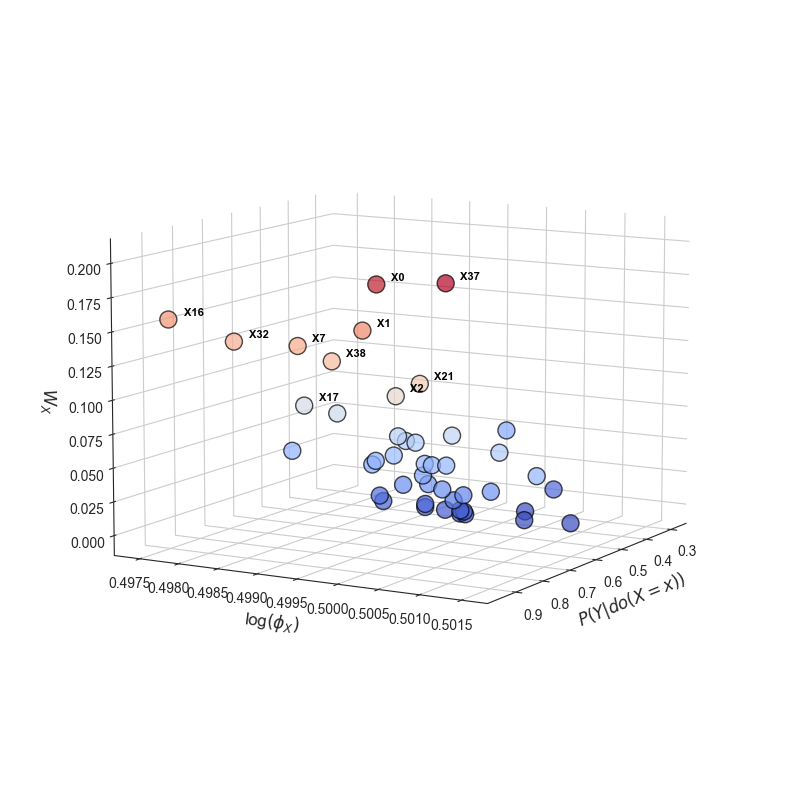

In [142]:
P_Y_do_X = rdf['doX']
phi_X = rdf['SHAP']
feature_names = rdf['Feature'] 
phi_scaled = sigmoid(phi_X)
w = (P_Y_do_X - phi_scaled) ** 2  

k = 10 
top_k_indices = np.argsort(w)[-k:] 

# Create Fig
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_facecolor('white')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

scatter = ax.scatter(
    P_Y_do_X, phi_scaled, w, 
    c=w, cmap='coolwarm', 
    edgecolor='k', alpha=.7, s=150
)

# Add labels with feature names for top k points
for i in top_k_indices:
    ax.text(P_Y_do_X.iloc[i]-0.05, phi_scaled.iloc[i], w.iloc[i],  
            feature_names.iloc[i], 
            color='black', fontsize=8, fontweight='bold')

# Adjust view
ax.view_init(elev=10, azim=30)

# Labels & appearance
ax.set_xlabel(r'$P(Y | do(X=x))$', fontsize=12, labelpad=10)
ax.set_ylabel(r'log' + r'$(\phi_X)$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$W_X$', fontsize=12, labelpad=10)
ax.set_box_aspect(None, zoom=0.85)
ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
ax.grid(True)

plt.tight_layout()
fig.savefig("Figures/W_MEASURE_NOABS_V2_PLOT.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as high-quality PNG
plt.show()

In [143]:
rdf = rdf.rename(columns={'W_X': 'Mean'}) # lazy
rdf.head()

,Feature,SHAP,doX,Mean
0,X0,0.001125,0.944721,0.197527
1,X1,-0.000188,0.900621,0.160535
2,X2,0.000472,0.831875,0.110063
3,X3,0.000028,0.566240,0.004387
4,X4,0.004667,0.496654,0.000020


In [95]:
import random
from pandas.testing import assert_frame_equal

In [144]:
# Suffle for spur_candidates

rdf = rdf.sort_values(by='Mean', ascending=False) # Change ascend mode
rdf.reset_index(inplace=True, drop=True)

spur_candidate = []

for index, row in rdf.iterrows():
    if index < 5: # 5
        spur_candidate.append(row['Feature'])
        
print(f'\n[i] Spurious Candidates :      {spur_candidate}')

# Shuffle 
sdf = df.copy()

for f in spur_candidate:
    tdf = list(sdf[f])
    i = 1
    while i < 10000: # probably to much
        random.shuffle(tdf)
        i+=1
    sdf[f] = tdf

# Check false - we randomized effectively
if df.equals(sdf) == False:
    print(f'[+] Finished!\n')


[i] Spurious Candidates :      ['X37', 'X0', 'X1', 'X16', 'X7']
[+] Finished!



In [145]:
# Before shuffle, train DNN on regular (OOD) data

X_biased = df.drop(['Y'],axis=1).values # drop T_xxx 
y_biased = df['Y'].astype(int).values
X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)

# Configuration for vanilla MLP
def_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
def_mlp.fit(X_train_biased, y_train_biased)

# Shuffle for all top 5 spurrious
X_shuf = sdf.drop(['Y'],axis=1).values 
y_shuf = sdf['Y'].astype(int).values
X_train_shuf,X_test_shuf,y_train_shuf,y_test_shuf = train_test_split(X_shuf,y_shuf,random_state=0)

shuf_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
shuf_mlp.fit(X_train_shuf, y_train_shuf)

shuf_y_pred = shuf_mlp.predict(X_test_shuf)
def_y_pred = def_mlp.predict(X_test_shuf)


# check perf
print(f'\n====== CAUSAL MLP ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf, shuf_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf, shuf_y_pred)}')

print(f'\n====== VANILLA MLP ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf, def_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf, def_y_pred)}')


====== CAUSAL MLP ======

F1        : 0.851063829787234
ROC-AUC   : 0.8723865374808772

====== VANILLA MLP ======

F1        : 0.8275862068965518
ROC-AUC   : 0.8535186129525754


In [146]:
v_ood_rf_df = pd.DataFrame()
v_ood_rf_df['metric'] = ['F1', 'ROC AUC']
v_ood_rf_df['Vanilla MLP'] = [metrics.f1_score(y_test_shuf, def_y_pred), metrics.roc_auc_score(y_test_shuf, def_y_pred)]
v_ood_rf_df['Causal MLP'] = [metrics.f1_score(y_test_shuf, shuf_y_pred), metrics.roc_auc_score(y_test_shuf, shuf_y_pred)]
#v_ood_rf_df.to_csv('Exports/VANILLA_OOD_MLP_BENCHMARK.csv', index=False)
v_ood_rf_df

,metric,Vanilla MLP,Causal MLP
0,F1,0.827586,0.851064
1,ROC AUC,0.853519,0.872387


## Shuffle top spurious candidates

In [147]:
# Plot metrics for models trained on 1 to 10 suffled columns

# Suffle for spur_candidates

spur_candidate = []
for index, row in rdf.iterrows():
    if index < 20: 
        spur_candidate.append(row['Feature'])        
print(f'Spurious Candidates : {spur_candidate}')

# Dict for dfs & copy original

new_dfs = {}
odf = df.copy()

# Iterate on candidates func

def iterative_shuffle(candidates, dataframe):
    
    for i in range(len(candidates)):
    
        df_copy = dataframe.copy()
        
        for j in range(len(candidates[:i+1])):
        
            name_j = candidates[j]
            values_j = list(dataframe[name_j])
            count = 1
            
            while count < 10:
                random.shuffle(values_j)
                count += 1

            df_copy[name_j] = values_j

        new_dfs[f'copy_{i + 1}'] = df_copy 
    print('Done!')
    
# Iterate on candidates

iterative_shuffle(spur_candidate, odf)

Spurious Candidates : ['X37', 'X0', 'X1', 'X16', 'X7', 'X32', 'X38', 'X21', 'X2', 'X17', 'X27', 'X14', 'X30', 'X35', 'X13', 'X29', 'X33', 'X41', 'X6', 'X34']
Done!


In [148]:
# old values

list_f1_ood = []
list_auc_ood = []

list_f1_biased = []
list_auc_biased = []

# Train model on biased dataset (original)

X_biased = df.drop(['Y', df.iloc[:,-1:].columns[0]],axis=1).values 
y_biased = df['Y'].astype(int).values

X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)

def_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
def_mlp.fit(X_train_biased, y_train_biased)

# Train a debiased model on each dataset from new_dfs

for name, shuffled_df in new_dfs.items():

    print(f"Training OOD DNN on {name}")
    
    X_shuf = shuffled_df.drop(['Y', shuffled_df.iloc[:,-1:].columns[0]],axis=1).values 
    y_shuf = shuffled_df['Y'].astype(int).values
    X_train_shuf,X_test_shuf,y_train_shuf,y_test_shuf = train_test_split(X_shuf,y_shuf,random_state=0)

    shuf_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
    shuf_mlp.fit(X_train_shuf, y_train_shuf)

    print(f"Testing OOD DNN on {name}")
    
    shuf_y_pred = shuf_mlp.predict(X_test_shuf)
    list_f1_ood.append(metrics.f1_score(y_test_shuf, shuf_y_pred))
    list_auc_ood.append(metrics.roc_auc_score(y_test_shuf, shuf_y_pred))
        
    print(f"Testing Biased DNN on {name}")
    
    def_y_pred = def_mlp.predict(X_test_shuf)
    list_f1_biased.append(metrics.f1_score(y_test_shuf, def_y_pred))
    list_auc_biased.append(metrics.roc_auc_score(y_test_shuf, def_y_pred))

Training OOD DNN on copy_1
Testing OOD DNN on copy_1
Testing Biased DNN on copy_1
Training OOD DNN on copy_2
Testing OOD DNN on copy_2
Testing Biased DNN on copy_2
Training OOD DNN on copy_3
Testing OOD DNN on copy_3
Testing Biased DNN on copy_3
Training OOD DNN on copy_4
Testing OOD DNN on copy_4
Testing Biased DNN on copy_4
Training OOD DNN on copy_5
Testing OOD DNN on copy_5
Testing Biased DNN on copy_5
Training OOD DNN on copy_6
Testing OOD DNN on copy_6
Testing Biased DNN on copy_6
Training OOD DNN on copy_7
Testing OOD DNN on copy_7
Testing Biased DNN on copy_7
Training OOD DNN on copy_8
Testing OOD DNN on copy_8
Testing Biased DNN on copy_8
Training OOD DNN on copy_9
Testing OOD DNN on copy_9
Testing Biased DNN on copy_9
Training OOD DNN on copy_10
Testing OOD DNN on copy_10
Testing Biased DNN on copy_10
Training OOD DNN on copy_11
Testing OOD DNN on copy_11
Testing Biased DNN on copy_11
Training OOD DNN on copy_12
Testing OOD DNN on copy_12
Testing Biased DNN on copy_12
Trainin

In [150]:
final_scores = pd.DataFrame()

c1 = []
for f in spur_candidate:
    n = f'+{f}'
    c1.append(n)

n_feat = [i for i in range(1,len(spur_candidate)+1)]

final_scores['Iteration'] = c1
final_scores['Total shuffled'] = n_feat
final_scores['CDNN F1'] = list_f1_ood 
final_scores['CDNN ROC AUC'] = list_auc_ood
final_scores['DNN F1'] = list_f1_biased 
final_scores['DNN ROC AUC'] = list_auc_biased
final_scores['Delta F1'] = final_scores['CDNN F1'] - final_scores['DNN F1']
final_scores['Delta ROC AUC'] = final_scores['CDNN ROC AUC'] - final_scores['DNN ROC AUC']


final_scores.to_csv('Exports/WV2_TOP20_SHUFFLED_FINAL_SCORES.csv', index=False)
final_scores

,Iteration,Total shuffled,CDNN F1,CDNN ROC AUC,DNN F1,DNN ROC AUC,Delta F1,Delta ROC AUC
0,+X37,1,0.827586,0.853519,0.861111,0.881183,-0.033525,-0.027664
1,+X0,2,0.891892,0.908210,0.847222,0.869709,0.044670,0.038501
2,+X1,3,0.851351,0.873789,0.826667,0.852881,0.024685,0.020908
3,+X16,4,0.773723,0.810938,0.816327,0.844085,-0.042604,-0.033146
4,+X7,5,0.841379,0.864992,0.769231,0.805584,0.072149,0.059408
5,+X32,6,0.821918,0.848802,0.693333,0.738144,0.128584,0.110658
6,+X38,7,0.771429,0.808261,0.675676,0.724630,0.095753,0.083631
7,+X21,8,0.824324,0.850841,0.676056,0.729985,0.148268,0.120857
8,+X2,9,0.729730,0.770525,0.666667,0.717874,0.063063,0.052652
9,+X17,10,0.742424,0.788628,0.690141,0.741458,0.052283,0.047170


<Figure size 1200x1200 with 0 Axes>

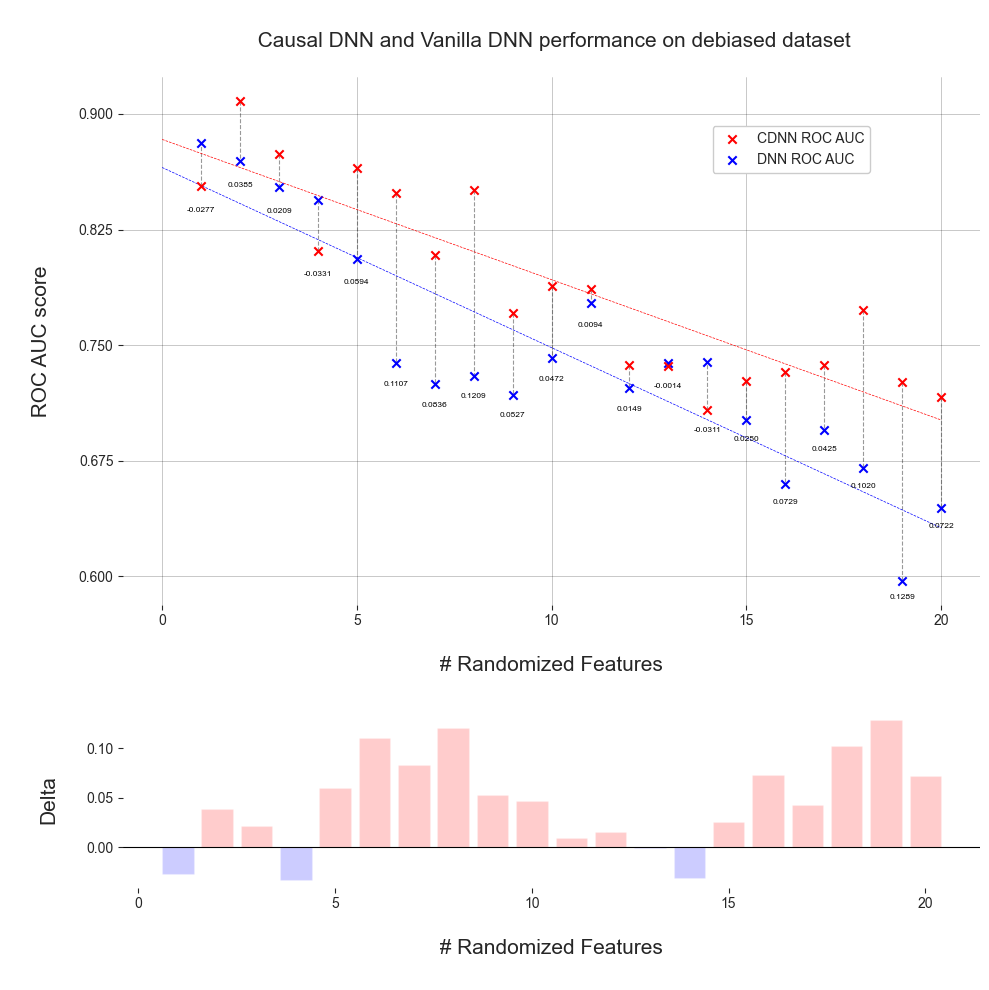

In [151]:
plt.figure(figsize=(12,12))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.scatter(x="Total shuffled", y="CDNN ROC AUC", data=final_scores, color='red', zorder=3, label='CDNN ROC AUC', marker='x')
ax1.scatter(x="Total shuffled", y="DNN ROC AUC", data=final_scores, color='blue', zorder=2, label='DNN ROC AUC', marker='x')

# Regression line

causal_b, causal_a = np.polyfit(x=final_scores['Total shuffled'], y=final_scores['CDNN ROC AUC'], deg=1)
causal_xseq = np.linspace(0, 20, num=100)
ax1.plot(causal_xseq, causal_a + causal_b * causal_xseq, color="red", lw=0.5, linestyle='--')

ood_b, ood_a = np.polyfit(x=final_scores['Total shuffled'], y=final_scores['DNN ROC AUC'], deg=1)
ood_xseq = np.linspace(0, 20, num=100)
ax1.plot(ood_xseq, ood_a + ood_b * ood_xseq, color="blue", lw=0.5, linestyle='--')


for i in range(len(final_scores)):
    
    x = final_scores["Total shuffled"].iloc[i]
    ycdnn = final_scores["CDNN ROC AUC"].iloc[i]
    ydnn = final_scores["DNN ROC AUC"].iloc[i]

    ax1.plot([x, x], [ycdnn, ydnn], '--', color='black', linewidth=.8, zorder=1, alpha=.4)  
    difference = ycdnn - ydnn
    ax1.text(x, min(ycdnn, ydnn) - min(ycdnn, ydnn) * 0.02, f'{difference:.4f}', fontsize=6, color='black', ha='center')

ax1.set_ylabel("\n ROC AUC score \n", fontsize=15)
ax1.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax1.set_xticks(np.linspace(0, 20, num=5))
ax1.set_yticks(np.linspace(0.6, .9, num=5))

ax1.set_title("\n Causal DNN and Vanilla DNN performance on debiased dataset\n", fontsize=15)
ax1.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
ax1.legend(loc='upper right', fontsize=10, frameon=True, bbox_to_anchor=(0.88, 0.92), framealpha=1)

for spine in ax1.spines.values():
    spine.set_visible(False)

colors = np.where(final_scores['Delta ROC AUC'] <= 0, 'blue', 'red')
ax2.bar(final_scores["Total shuffled"], final_scores["Delta ROC AUC"], color=colors, alpha=.2)
ax2.set_ylabel("Delta\n", fontsize=15)
ax2.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(np.linspace(0, 20, num=5))

for spine in ax2.spines.values():
    spine.set_visible(False)

plt.draw()
#plt.savefig('Figures/FIG22_TOP20_BENCHMARK_ROCAUC_REG.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

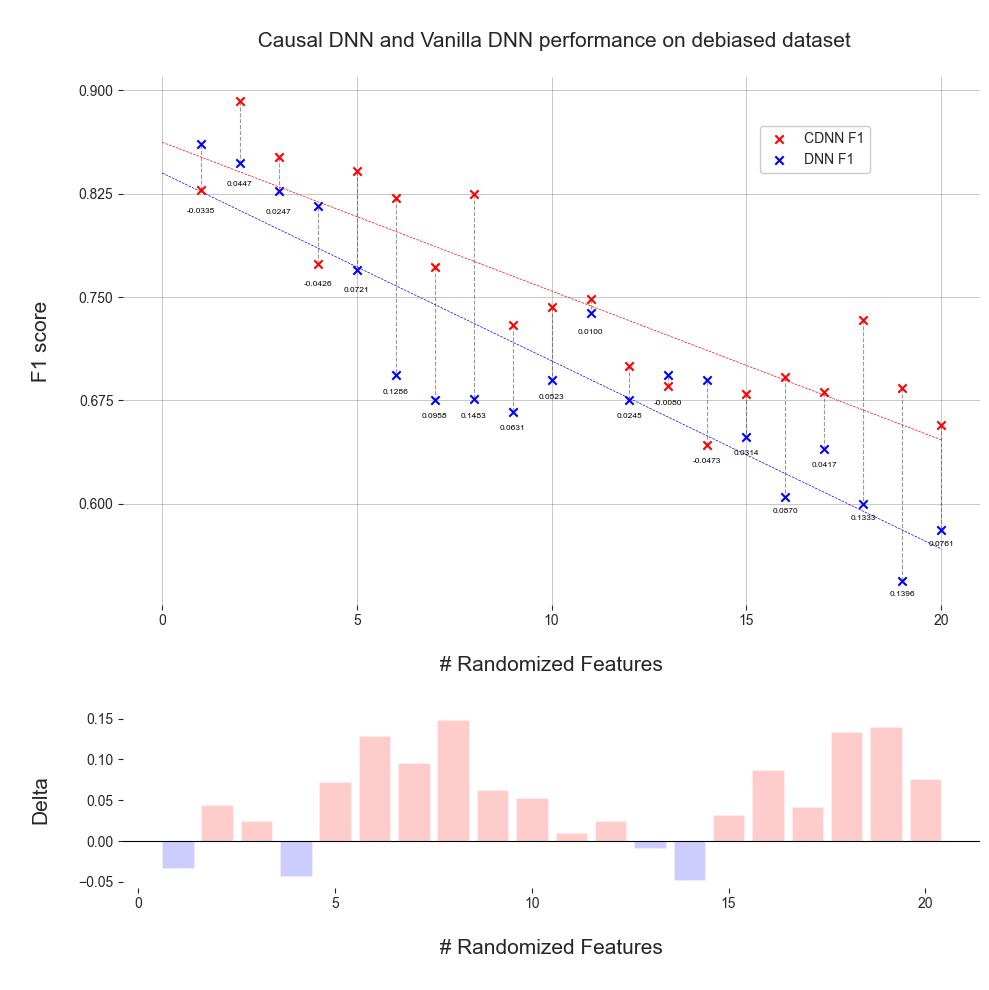

In [152]:
plt.figure(figsize=(12,12))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.scatter(x="Total shuffled", y="CDNN F1", data=final_scores, color='red', zorder=3, label='CDNN F1', marker='x')
ax1.scatter(x="Total shuffled", y="DNN F1", data=final_scores, color='blue', zorder=2, label='DNN F1', marker='x')

# Regression line

causal_b, causal_a = np.polyfit(x=final_scores['Total shuffled'], y=final_scores['CDNN F1'], deg=1)
causal_xseq = np.linspace(0, 20, num=100)
ax1.plot(causal_xseq, causal_a + causal_b * causal_xseq, color="red", lw=0.5, linestyle='--')

ood_b, ood_a = np.polyfit(x=final_scores['Total shuffled'], y=final_scores['DNN F1'], deg=1)
ood_xseq = np.linspace(0, 20, num=100)
ax1.plot(ood_xseq, ood_a + ood_b * ood_xseq, color="blue", lw=0.5, linestyle='--')

for i in range(len(final_scores)):
    
    x = final_scores["Total shuffled"].iloc[i]
    ycdnn = final_scores["CDNN F1"].iloc[i]
    ydnn = final_scores["DNN F1"].iloc[i]

    ax1.plot([x, x], [ycdnn, ydnn], '--', color='black', linewidth=.8, zorder=1, alpha=.4)  
    difference = ycdnn - ydnn
    ax1.text(x, min(ycdnn, ydnn) - min(ycdnn, ydnn) * 0.02, f'{difference:.4f}', fontsize=6, color='black', ha='center')

ax1.set_ylabel("\n F1 score \n", fontsize=15)
ax1.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax1.set_xticks(np.linspace(0, 20, num=5))
ax1.set_yticks(np.linspace(0.6, .9, num=5))

ax1.set_title("\n Causal DNN and Vanilla DNN performance on debiased dataset\n", fontsize=15)
ax1.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
ax1.legend(loc='upper right', fontsize=10, frameon=True, bbox_to_anchor=(0.88, 0.92), framealpha=1)

for spine in ax1.spines.values():
    spine.set_visible(False)

colors = np.where(final_scores['Delta F1'] <= 0, 'blue', 'red')
ax2.bar(final_scores["Total shuffled"], final_scores["Delta F1"], color=colors, alpha=.2)
ax2.set_ylabel("Delta\n", fontsize=15)
ax2.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(np.linspace(0, 20, num=5))

for spine in ax2.spines.values():
    spine.set_visible(False)

plt.draw()
plt.savefig('Figures/FIG21_TOP20_BENCHMARK_F1_REG.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

In [153]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

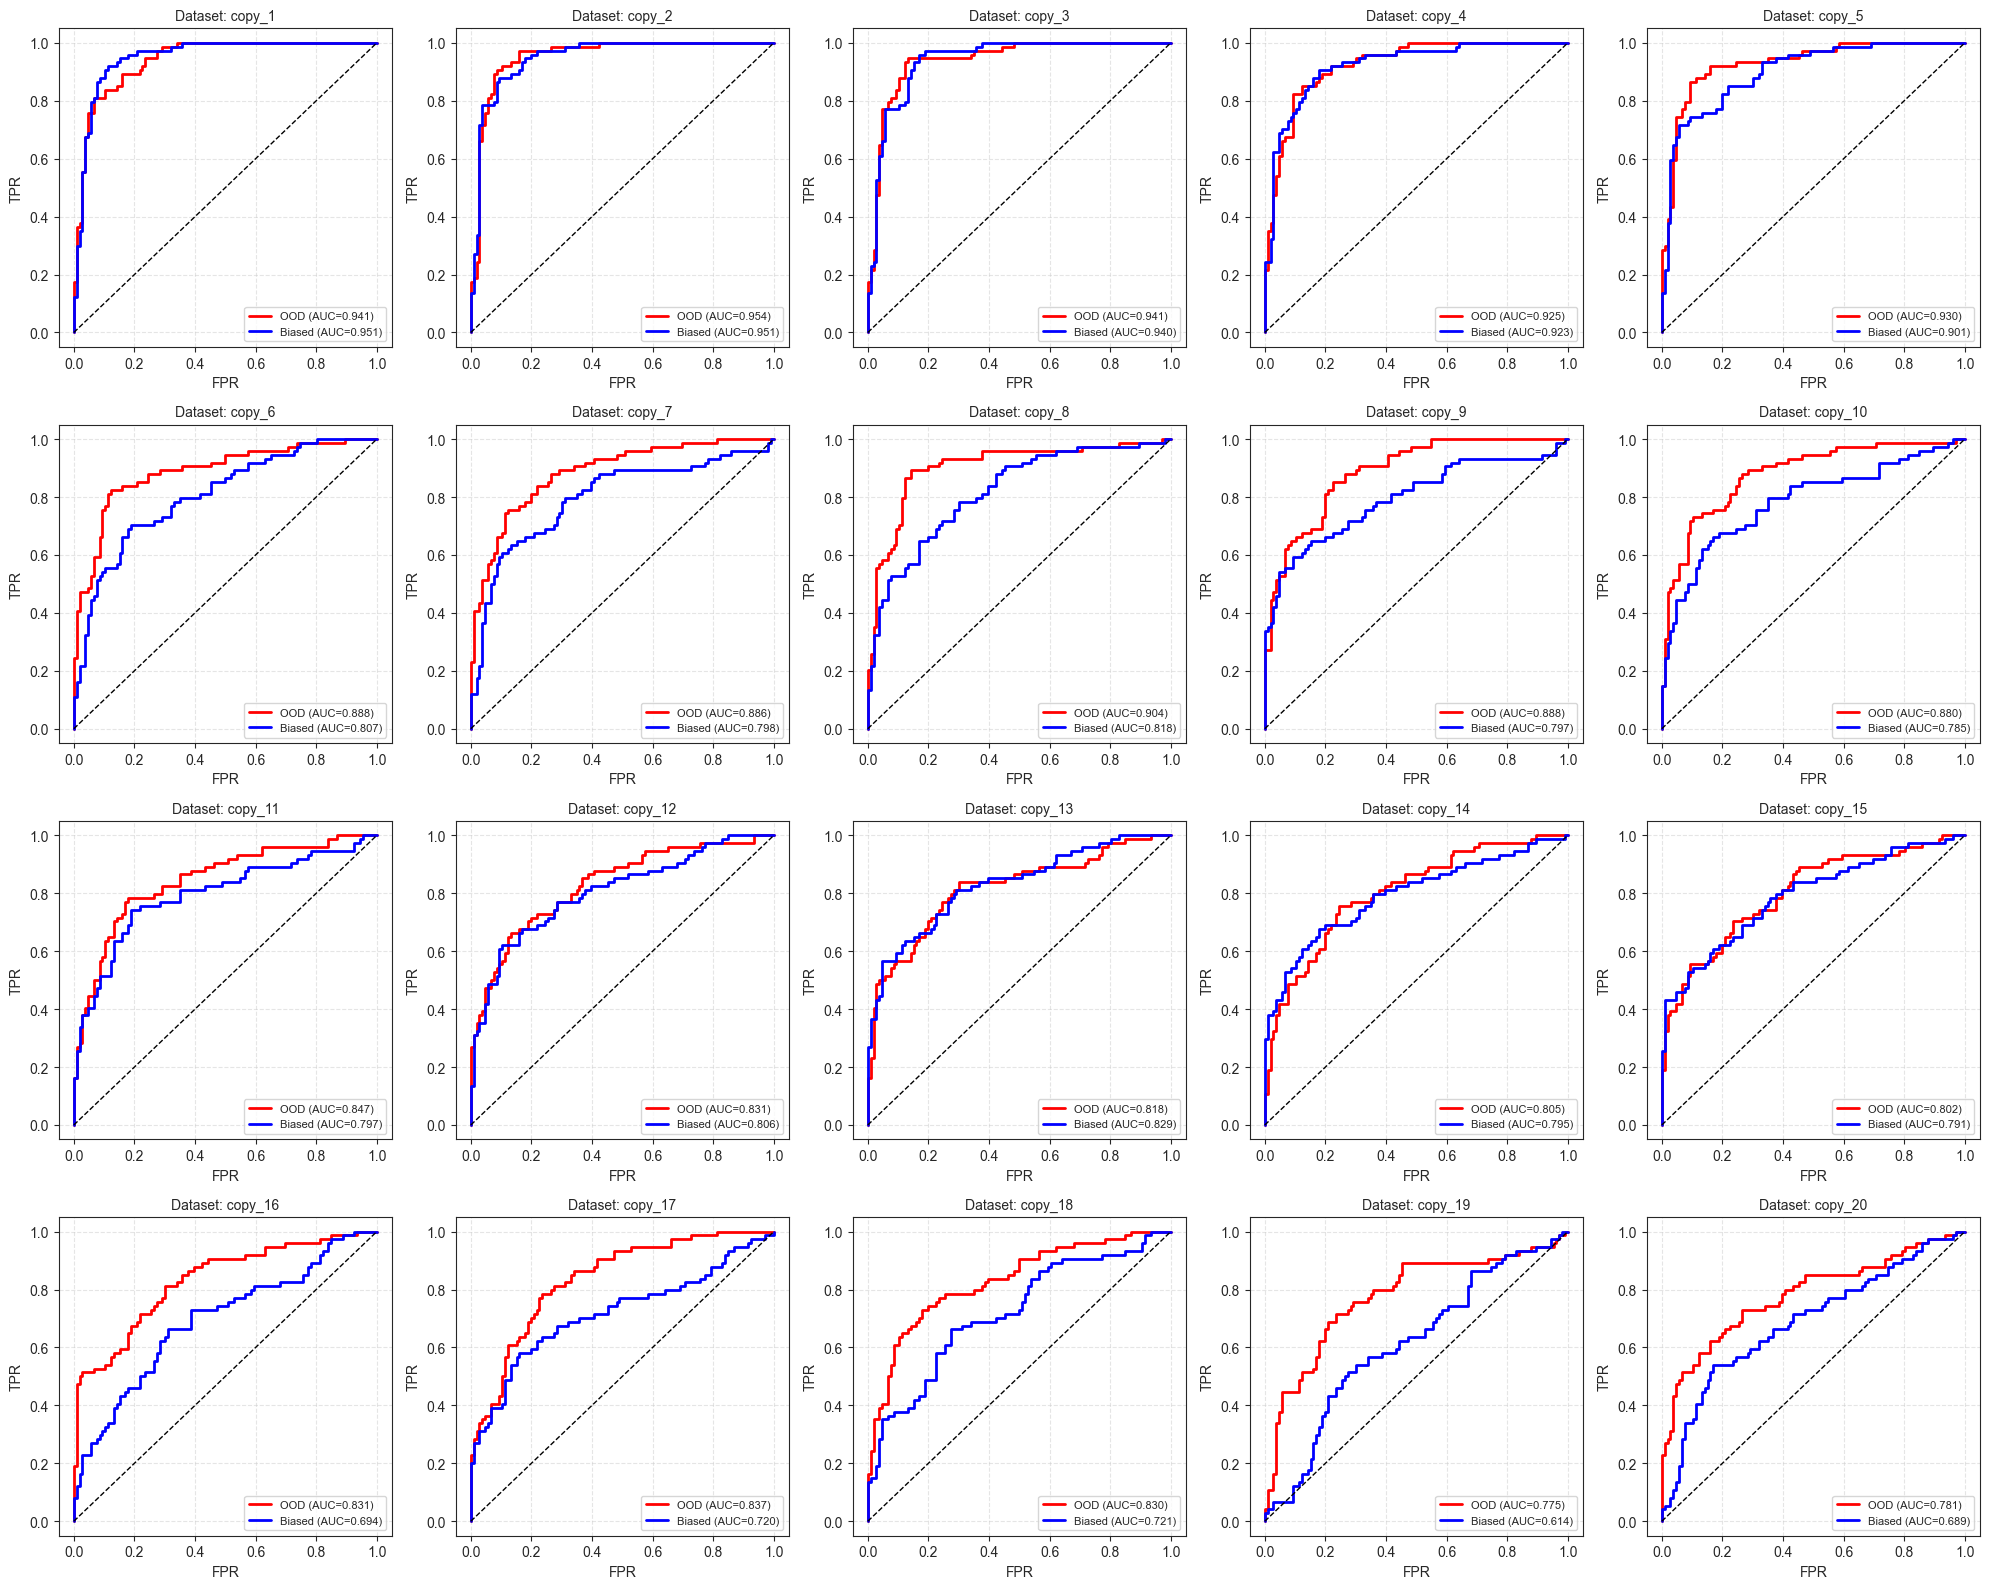

In [156]:
# Select the first 20 datasets
selected_datasets = list(new_dfs.keys())[:20]

# Create a figure with a 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten to easily loop through subplots

# Loop through the first 20 datasets
for i, name in enumerate(selected_datasets):
    shuffled_df = new_dfs[name]

    # Prepare data
    X_shuf = shuffled_df.drop(['Y', shuffled_df.iloc[:, -1:].columns[0]], axis=1).values
    y_shuf = shuffled_df['Y'].astype(int).values
    X_train_shuf, X_test_shuf, y_train_shuf, y_test_shuf = train_test_split(X_shuf, y_shuf, random_state=0)

    # Train OOD model
    shuf_mlp = MLPClassifier(solver='adam', activation='relu', alpha=1e-2,
                             hidden_layer_sizes=(64, 32, 32, 16, 8), random_state=4,
                             max_iter=100, learning_rate_init=.01)
    shuf_mlp.fit(X_train_shuf, y_train_shuf)

    # Predictions for both models
    shuf_y_prob = shuf_mlp.predict_proba(X_test_shuf)[:, 1]  # OOD model probabilities
    def_y_prob = def_mlp.predict_proba(X_test_shuf)[:, 1]  # Biased model probabilities

    # Compute ROC curves
    fpr_shuf, tpr_shuf, _ = roc_curve(y_test_shuf, shuf_y_prob)
    auc_shuf = auc(fpr_shuf, tpr_shuf)

    fpr_def, tpr_def, _ = roc_curve(y_test_shuf, def_y_prob)
    auc_def = auc(fpr_def, tpr_def)

    # Select subplot
    ax = axes[i]
    
    # Plot ROC Curves
    ax.plot(fpr_shuf, tpr_shuf, color='red', lw=2, label=f'OOD (AUC={auc_shuf:.3f})')
    ax.plot(fpr_def, tpr_def, color='blue', lw=2, label=f'Biased (AUC={auc_def:.3f})')

    # Random baseline
    ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=1)

    # Titles & Labels
    ax.set_title(f"Dataset: {name}", fontsize=10)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [157]:
from scipy.stats import sem  # Standard Error of Mean

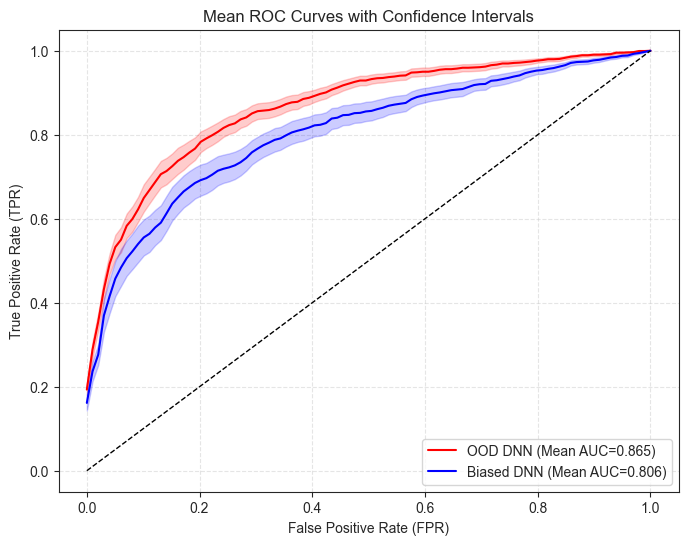

In [158]:
# Storage for ROC curves
fpr_values_shuf = []
tpr_values_shuf = []
auc_values_shuf = []

fpr_values_def = []
tpr_values_def = []
auc_values_def = []

# Process all datasets
for name, shuffled_df in list(new_dfs.items())[:20]:  # First 20 datasets
    X_shuf = shuffled_df.drop(['Y', shuffled_df.iloc[:, -1:].columns[0]], axis=1).values
    y_shuf = shuffled_df['Y'].astype(int).values
    X_train_shuf, X_test_shuf, y_train_shuf, y_test_shuf = train_test_split(X_shuf, y_shuf, random_state=0)

    # Train causal OOD model
    shuf_mlp = MLPClassifier(solver='adam', activation='relu', alpha=1e-2,
                             hidden_layer_sizes=(64, 32, 32, 16, 8), random_state=4,
                             max_iter=100, learning_rate_init=.01)
    shuf_mlp.fit(X_train_shuf, y_train_shuf)

    # Predictions
    shuf_y_prob = shuf_mlp.predict_proba(X_test_shuf)[:, 1]
    def_y_prob = def_mlp.predict_proba(X_test_shuf)[:, 1]

    # Compute ROC
    fpr_shuf, tpr_shuf, _ = roc_curve(y_test_shuf, shuf_y_prob)
    fpr_def, tpr_def, _ = roc_curve(y_test_shuf, def_y_prob)

    auc_values_shuf.append(auc(fpr_shuf, tpr_shuf))
    auc_values_def.append(auc(fpr_def, tpr_def))

    fpr_values_shuf.append(np.interp(np.linspace(0, 1, 100), fpr_shuf, tpr_shuf))
    fpr_values_def.append(np.interp(np.linspace(0, 1, 100), fpr_def, tpr_def))

# Compute mean and confidence intervals
mean_tpr_shuf = np.mean(fpr_values_shuf, axis=0)
std_tpr_shuf = sem(fpr_values_shuf, axis=0)

mean_tpr_def = np.mean(fpr_values_def, axis=0)
std_tpr_def = sem(fpr_values_def, axis=0)

# Plot Mean ROC Curve
plt.figure(figsize=(8, 6))

plt.plot(np.linspace(0, 1, 100), mean_tpr_shuf, color='red', label=f'OOD DNN (Mean AUC={np.mean(auc_values_shuf):.3f})')
plt.fill_between(np.linspace(0, 1, 100), mean_tpr_shuf - std_tpr_shuf, mean_tpr_shuf + std_tpr_shuf, color='red', alpha=0.2)

plt.plot(np.linspace(0, 1, 100), mean_tpr_def, color='blue', label=f'Biased DNN (Mean AUC={np.mean(auc_values_def):.3f})')
plt.fill_between(np.linspace(0, 1, 100), mean_tpr_def - std_tpr_def, mean_tpr_def + std_tpr_def, color='blue', alpha=0.2)

# Random baseline
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', linewidth=1)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Mean ROC Curves with Confidence Intervals")
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

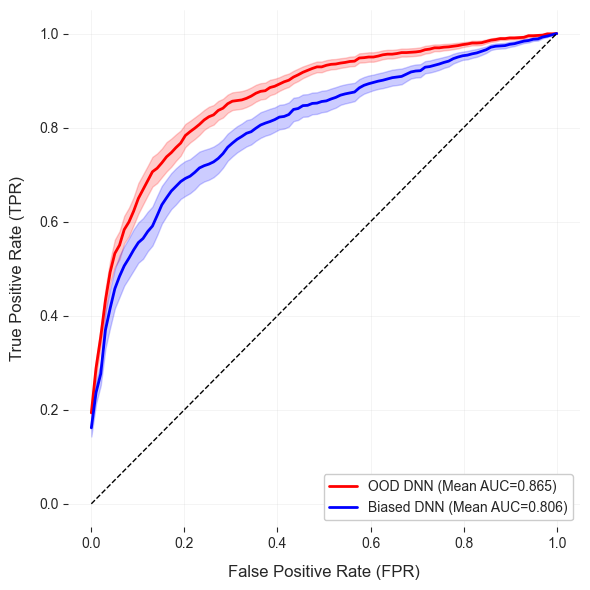

In [161]:
# Compute mean and confidence interval
mean_tpr_shuf = np.mean(fpr_values_shuf, axis=0)
std_tpr_shuf = sem(fpr_values_shuf, axis=0)

mean_tpr_def = np.mean(fpr_values_def, axis=0)
std_tpr_def = sem(fpr_values_def, axis=0)

# Create Figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor('white')  # White background

# Mean ROC Curves
ax.plot(np.linspace(0, 1, 100), mean_tpr_shuf, color='red', label=f'OOD DNN (Mean AUC={np.mean(auc_values_shuf):.3f})', linewidth=2)
ax.fill_between(np.linspace(0, 1, 100), mean_tpr_shuf - std_tpr_shuf, mean_tpr_shuf + std_tpr_shuf, color='red', alpha=0.2)

ax.plot(np.linspace(0, 1, 100), mean_tpr_def, color='blue', label=f'Biased DNN (Mean AUC={np.mean(auc_values_def):.3f})', linewidth=2)
ax.fill_between(np.linspace(0, 1, 100), mean_tpr_def - std_tpr_def, mean_tpr_def + std_tpr_def, color='blue', alpha=0.2)

# Random baseline
ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', linewidth=1)

# Labels & Styling
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12, labelpad=10)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=12, labelpad=10)
#ax.set_title("Mean ROC Curves with Confidence Intervals", fontsize=14, pad=15)

# Grid and Spines
ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)
for spine in ax.spines.values():
    spine.set_visible(False)  # Remove plot borders

# Legend
ax.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)

# Show Plot
plt.draw()
plt.savefig('Figures/ROC_BENCHMARK_SME.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

In [162]:
data = pd.read_csv('Exports/WV2_TOP20_SHUFFLED_FINAL_SCORES.csv')

In [163]:
avg_f1_gain = sum(data["Delta F1"])/len(data["Delta F1"])
print(f'F1 Gain                      : {avg_f1_gain:.4f}')

avg_f1_gain_x5 = sum(data["Delta F1"][-5:])/len(data["Delta F1"][-5:])
print(f'F1 Gain (xtrem 5)            : {avg_f1_gain_x5:.4f}')

avg_roc_gain = sum(data["Delta ROC AUC"])/len(data["Delta ROC AUC"])
print(f'ROC AUC Gain                 : {avg_roc_gain:.4f}')

avg_roc_gain_x5 = sum(data["Delta ROC AUC"][-5:])/len(data["Delta ROC AUC"][-5:])
print(f'ROC AUC Gain (xtrem 5)       : {avg_roc_gain_x5:.4f}')

F1 Gain                      : 0.0521
F1 Gain (xtrem 5)            : 0.0955
ROC AUC Gain                 : 0.0454
ROC AUC Gain (xtrem 5)       : 0.0837


In [164]:
data.to_csv('Exports/W2-ablation_study.csv', index=False, float_format='%.4f')

In [165]:
top5 = 0
top10 = 0

for index, row in data[-5:].iterrows():
    gain = row["Delta F1"]/row["DNN F1"]*100
    top5+=gain

for index, row in data[-10:].iterrows():
    gain = row["Delta F1"]/row["DNN F1"]*100
    top10+=gain


top5 = top5/5
print(f'Xtrem 5 F1 gain     : {top5:.6f}')

top10 = top10/10
print(f'Xtrem 10 F1 gain    : {top10:.6f}')

max_gain_idx = data['Delta F1'].idxmax()
max_gain = (data['Delta F1'][max_gain_idx]/data['DNN F1'][max_gain_idx])*100
print(f'Max gain F1         : {max_gain:.6f}')

top5 = 0
top10 = 0

for index, row in data[-5:].iterrows():
    gain = row["Delta ROC AUC"]/row["DNN ROC AUC"]*100
    top5+=gain

for index, row in data[-10:].iterrows():
    gain = row["Delta ROC AUC"]/row["DNN ROC AUC"]*100
    top10+=gain


top5 = top5/5
print(f'Xtrem 5 ROC AUC gain     : {top5:.6f}')

top10 = top10/10
print(f'Xtrem 10 ROC AUC gain    : {top10:.6f}')

max_gain_idx = data['Delta ROC AUC'].idxmax()
max_gain = (data['Delta ROC AUC'][max_gain_idx]/data['DNN ROC AUC'][max_gain_idx])*100
print(f'Max gain ROC AUC         : {max_gain:.6f}')

Xtrem 5 F1 gain     : 16.371269
Xtrem 10 F1 gain    : 8.365982
Max gain F1         : 21.931306
Xtrem 5 ROC AUC gain     : 13.030453
Xtrem 10 ROC AUC gain    : 6.759256
Max gain ROC AUC         : 21.584116


In [173]:
data.

,Iteration,Total shuffled,CDNN F1,CDNN ROC AUC,DNN F1,DNN ROC AUC,Delta F1,Delta ROC AUC
0,+X37,1,0.827586,0.853519,0.861111,0.881183,-0.033525,-0.027664
1,+X0,2,0.891892,0.908210,0.847222,0.869709,0.044670,0.038501
2,+X1,3,0.851351,0.873789,0.826667,0.852881,0.024685,0.020908
3,+X16,4,0.773723,0.810938,0.816327,0.844085,-0.042604,-0.033146
4,+X7,5,0.841379,0.864992,0.769231,0.805584,0.072149,0.059408
5,+X32,6,0.821918,0.848802,0.693333,0.738144,0.128584,0.110658
6,+X38,7,0.771429,0.808261,0.675676,0.724630,0.095753,0.083631
7,+X21,8,0.824324,0.850841,0.676056,0.729985,0.148268,0.120857
8,+X2,9,0.729730,0.770525,0.666667,0.717874,0.063063,0.052652
9,+X17,10,0.742424,0.788628,0.690141,0.741458,0.052283,0.047170


# Iterative Optimizer

In [166]:
# 1. Initiate DoX Table

opt_df = pd.DataFrame()
opt_df['X'] = doXdf.X
opt_df['doX'] = doXdf.doX
opt_df.head()

,X,doX
0,X0,0.944721
1,X1,0.900621
2,X2,0.831875
3,X3,0.566240
4,X4,0.496654


In [167]:
# Train initial model

X_biased = df.drop('Y',axis=1).values 
y_biased = df['Y'].astype(int).values

X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)

mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
mlp.fit(X_train_biased, y_train_biased)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(64, 32, 32, 16, 8),
              learning_rate_init=0.01, max_iter=100, random_state=4)

In [168]:
# Define loop function

def greedy_solver(model, max_iterations):

    # Dataframe to store results
    results = pd.DataFrame(columns=['Feature_Shuffled', 'F1 (After shuff)'])
    ftshufl = []
    f1l = []
    odf = df.copy()
    already_shuffled = []
    
    i = 0
    while i < max_iterations:
        
        # Get SHAP values
        shpexp = shap.Explainer(model.predict, test[X])
        shap_v = np.abs(shpexp(test[X]).values).mean(axis=0)[:45]
        n = test[X].columns[:45]
        rdf = pd.DataFrame({'Feature': n, 'SHAP': shap_v})
    
        # Compute (1-SHAP+doX)/2
        #rdf['doX'] = opt_df['doX']
        #lm = []
        #for index, row in rdf.iterrows():
        #    mean = ((row['SHAP'])+(1-row['doX']))/2
        #    lm.append(mean)
        #rdf['Coeff']=lm

        # Top N values returned are the candidates
        rdf['doX'] = opt_df['doX']
        lm = []
        
        for index, row in rdf.iterrows():
            phi_x = row['SHAP']
            P_Y_do_X = row['doX'] 
            phi_scaled = sigmoid(phi_x)
            w = (P_Y_do_X - phi_scaled) ** 2 
            lm.append(w)
        
        rdf['Coeff']=lm
        #rdf.sort_values(by="W_X", ascending=False).head()
    
        # Shuffle values
        for i in range(len(rdf.sort_values(by='Coeff', ascending=False)['Feature'])):
            if rdf.sort_values(by='Coeff', ascending=False).iloc[i]['Feature'] not in already_shuffled:
                ft_shuffle = rdf.sort_values(by='Coeff', ascending=False).iloc[i]['Feature']
                ftshufl.append(ft_shuffle)
                already_shuffled.append(ft_shuffle)
                break
        
        val_ft_shuffle = list(odf[ft_shuffle])
        count = 1
        while count < 5:
            random.shuffle(val_ft_shuffle)
            count += 1
        odf[ft_shuffle] = val_ft_shuffle

        # Replace initial model with new model
        X_biased = odf.drop('Y',axis=1).values 
        y_biased = odf['Y'].astype(int).values
        X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)
        
        model = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
        model.fit(X_train_biased, y_train_biased)    
        
        # Get model perf
        f1 = metrics.f1_score(y_test, model.predict(X_test))
        f1l.append(f1)
        
        i+=1

    # Return results
    results['Feature_Shuffled'] = ftshufl
    results['F1 (After shuff)'] = f1l
    return results

# Run
solverdf = greedy_solver(mlp, 20)
solverdf.head()

,Feature_Shuffled,F1 (After shuff)
0,X0,0.788732
1,X37,0.870748
2,X1,0.876712
3,X7,0.876712
4,X16,0.849315


In [169]:
solverdf.to_csv('Exports/W2-iterative_solver.csv', index=False)

In [171]:
solverdf

,Feature_Shuffled,F1 (After shuff)
0,X0,0.788732
1,X37,0.870748
2,X1,0.876712
3,X7,0.876712
4,X16,0.849315
5,X38,0.860927
6,X32,0.779874
7,X21,0.837838
8,X2,0.837838
9,X17,0.823529


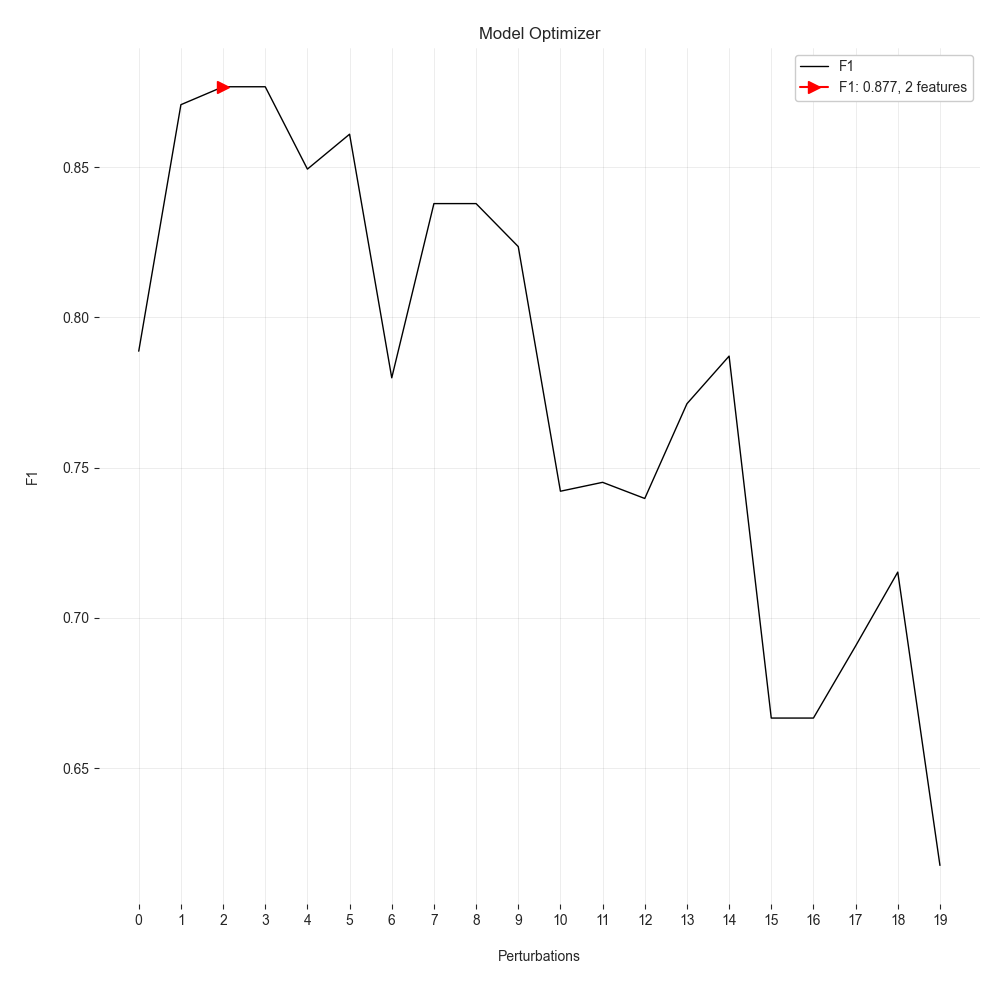

In [172]:
# plot results, X = nb of perturbations, Y = F1
# Best combination maximises the number of perturbations and F1

plt.figure(figsize=(10,10))

max_f1_idx = solverdf['F1 (After shuff)'].idxmax() 
max_f1 = solverdf['F1 (After shuff)'].max() 

plt.plot(solverdf['F1 (After shuff)'], color='black', label='F1',  linewidth=1)
plt.plot(max_f1_idx, max_f1, color='red', marker='>', label=f'F1: {max_f1:.3f}, {max_f1_idx} features', markersize=8)

plt.legend(loc='upper right', fontsize=10, frameon=True, framealpha=1)

plt.title(f"\nModel Optimizer", fontsize=12)
plt.ylabel("\nF1\n", fontsize=10)
plt.xlabel("\nPerturbations\n", fontsize=10)
plt.xticks(ticks=np.linspace(0, 19, num=20))

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.1)
plt.draw()
plt.box(False)
#plt.savefig('Figures/greed_optimizer.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

# (REMOVED FROM PAPER) PART V - INVESTIGATION PROTOCOL

The following protocol has been defined with the objective of identifying detection edge-cases during post-mortem investigations aka forensics:

> 1. Filter relevant logs, create dataset $D_{int} = (X,Z,Y,\hat{Y})$, where $X\gets$ events, $Z\gets$ Latent states, $Y\gets$ ground truth, $\hat{Y} \gets$ predictions 
> 2. Filter false negative (FN) samples, noted $ F = ( X_i, Z_i, \hat{Y}_i,Y_{i}) \subset D | \hat{Y_i} \neq Y_{i} ,Y_{i} =1$
> 3. Pick meta learners
> 4. Compute $ITE_F$ for features in $F$
> 5. Compute $CATE_D$ for features in $D$
> 6. If feature $ITE_F < CATE_D$, increase bias in neural network input layer, otherwise, decrease it
> 7. Re-test model, compare

In [34]:
# data sample
glist = []
X = df.drop(['Y'],axis=1).values
y = df['Y'].astype(int).values

# huge test size to get lot of False Negatives on a good model
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, df.index, random_state=0, test_size=0.4)

#train
mlp = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
mlp.fit(X_train, y_train)

# predict
mlp_y_pred = mlp.predict(X_test)

# scores
print()
print(f'F1        : {metrics.f1_score(y_test, mlp_y_pred)}')
print(f'Accuracy  : {metrics.accuracy_score(y_test, mlp_y_pred)}')
print(f'Precision : {metrics.precision_score(y_test, mlp_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test, mlp_y_pred)}')

glist.append(metrics.f1_score(y_test, mlp_y_pred))

# Step 1. Retrieve FN

mask = mlp_y_pred != y_test
FN = df.loc[test_idx[mask]]

# Step 2. Compute ITE of each X for these samples using S-learner

# Compute ATE for each signal

test = df.sample(frac=0.4, random_state=42)
train = df.loc[~df.index.isin(test.index)]

X = list(df.columns[:45])+list(df.columns[-3:]) 
y = 'Y'

dfITE = pd.DataFrame(columns=list(doXdf['X']))
s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
s_learner_dnn.fit(train[X], train[y])
dnn_ATE_s = []

for index_a, row_a in doXdf.iterrows():

    tl = []
    T =  row_a['X']
    for index, row in df.iterrows():
        if row[T] < 0 :
            tl.append(1)
        else:
            tl.append(0)
    
    xi_0 = df.copy()
    xi_1 = df.copy()
    xi_1[T] = tl

    dnn_f_x0 = s_learner_dnn.predict(xi_0[X])
    dnn_f_x1 = s_learner_dnn.predict(xi_1[X])
    dnn_ITE = []
    for i in range(len(dnn_f_x1)):
        dnn_ITE.append(dnn_f_x1[i]-dnn_f_x0[i])
        
    dfITE[T] = dnn_ITE
    
    dnn_ATE = (sum(dnn_ITE)/len(dnn_ITE))
    dnn_ATE_s.append(dnn_ATE)
  
doXdf['SL_DNN_ATE'] = dnn_ATE_s  

# Step 4. For samples in FN, what are the columns with highest ITE ?

# filter ITE for FN samples
FN_ITE = dfITE.loc[test_idx[mask]]

# Values are E(Y|X=0 - Y|X=1)
FN_ATE = FN_ITE.mean()
FN_ATE.sort_values() # these are our candidates

# For the candidates, verify if the FN_ATE is far from the CATE
scores = []

for index, row in doXdf.iterrows():
    score = abs(abs(row['SL_DNN_ATE']) - abs(FN_ATE[index]))
    scores.append(score)    

doXdf['CorrectionCoeff'] = scores

# these are the targets
doXdf.sort_values(by='CorrectionCoeff', ascending=False).head()


F1        : 0.8214285714285715
Accuracy  : 0.8611111111111112
Precision : 0.8288288288288288
ROC-AUC   : 0.8527939317319849


,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1,SL_RF_ATE,SL_DNN_ATE,TL_RF_ATE,TL_DNN_ATE,CorrectionCoeff
1,X1,0.900621,0.886206,0.915133,0.000000,0.000000,0.056944,0.306944,0.595833,0.584722,0.268056
44,X44,0.727497,0.129240,1.328532,1.000000,0.727497,0.000000,0.070833,0.590278,0.579167,0.229167
19,X19,0.668093,0.575675,0.756430,0.502451,0.335684,-0.005556,0.006944,0.176389,0.097222,0.168056
43,X43,0.718630,0.379227,1.060811,0.987745,0.709823,-0.001389,-0.009722,0.505556,0.354167,0.115278
29,X29,0.768611,0.510284,1.029715,0.992647,0.762959,-0.009722,0.044444,0.611111,0.522222,0.105556


In [28]:
cdf = doXdf[['X', 'CorrectionCoeff']]
cdf.columns=['Feature', 'W']
cdf.sort_values('W', ascending=False).to_csv('Exports/edge_cases.csv', index=False, float_format='%.4f')

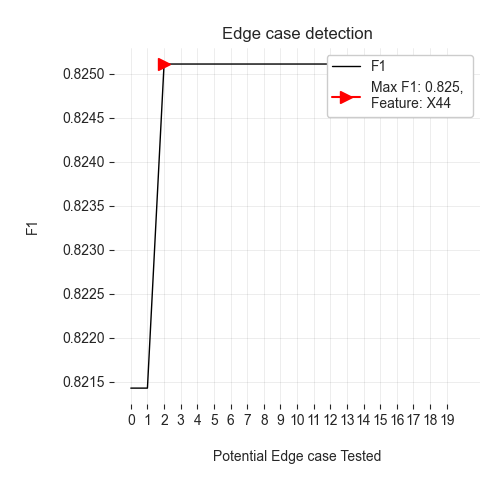

In [35]:
# now we must increase the weights for these features
protdf = pd.DataFrame(columns=['Feature', 'F1'])
targetFeatures = [idx for idx, row in doXdf.sort_values(by='CorrectionCoeff', ascending=False).head(20).iterrows()] 
layer = 0

f = []
f.append('None')

for targetFeature in targetFeatures:

    f.append(targetFeature)
    weight_increase = doXdf['CorrectionCoeff'][targetFeature]
    mlp.coefs_[0][targetFeature, layer] += weight_increase
    
    mlp_y_pred2 = mlp.predict(X_test)
    f1 = metrics.f1_score(y_test, mlp_y_pred2)
    glist.append(f1)

protdf['Feature'] = f
protdf['F1'] = glist

plt.figure(figsize=(10,10))

max_f1_idx = protdf['F1'].idxmax() 
max_f1_feature = protdf.loc[max_f1_idx, 'Feature']
max_f1 = protdf['F1'].max() 

plt.plot(protdf['F1'], color='black', label='F1',  linewidth=1)
plt.plot(max_f1_idx, max_f1, color='red', marker='>', label=f'Max F1: {max_f1:.3f}, \nFeature: X{max_f1_feature}', markersize=8)

plt.legend(loc='upper right', fontsize=10, frameon=True, framealpha=1)

plt.title(f"\nEdge case detection", fontsize=12)
plt.ylabel("\nF1\n", fontsize=10)
plt.xlabel("\n Potential Edge case Tested \n", fontsize=10)
plt.xticks(ticks=np.linspace(0, 19, num=20))

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.1)
plt.draw()
plt.box(False)
plt.savefig('Figures/protocol_edge_case.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

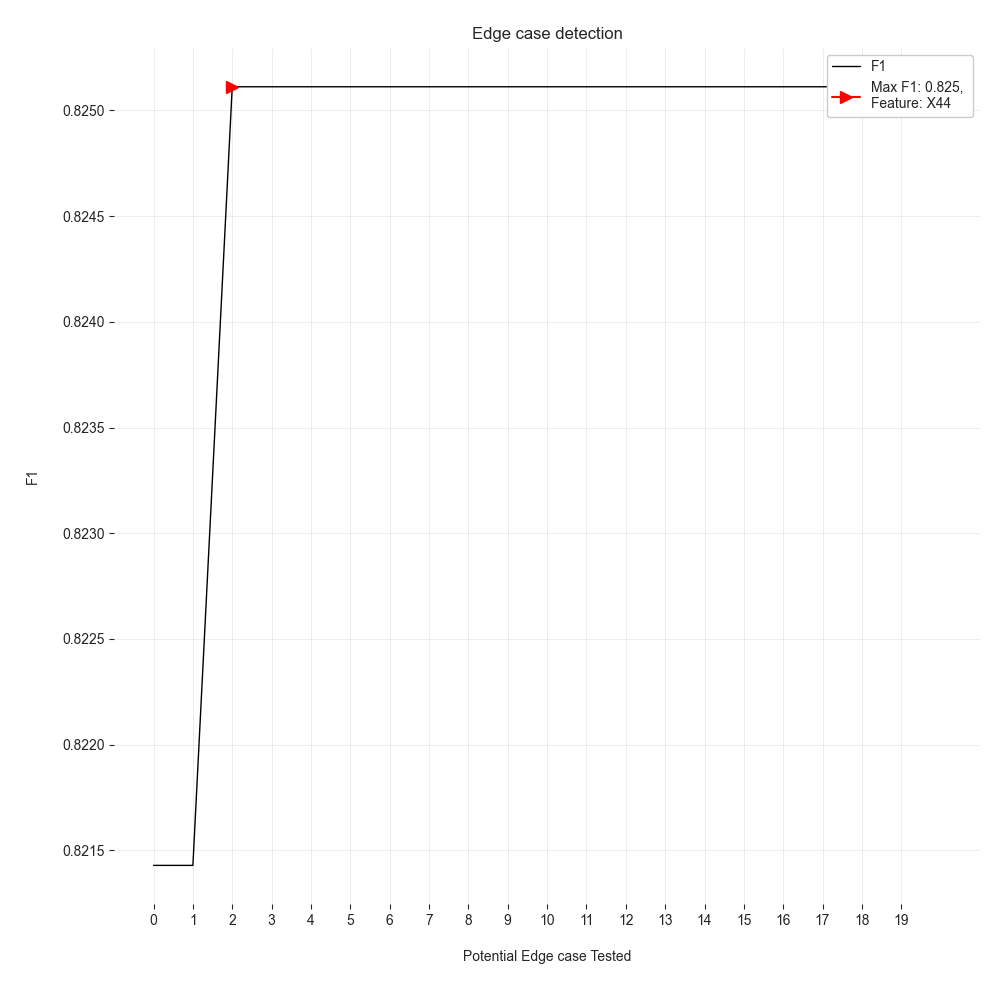

In [36]:
plt.figure(figsize=(10,10))

max_f1_idx = protdf['F1'].idxmax() 
max_f1_feature = protdf.loc[max_f1_idx, 'Feature']
max_f1 = protdf['F1'].max() 

plt.plot(protdf['F1'], color='black', label='F1',  linewidth=1)
plt.plot(max_f1_idx, max_f1, color='red', marker='>', label=f'Max F1: {max_f1:.3f}, \nFeature: X{max_f1_feature}', markersize=8)

plt.legend(loc='upper right', fontsize=10, frameon=True, framealpha=1)

plt.title(f"\nEdge case detection", fontsize=12)
plt.ylabel("\nF1\n", fontsize=10)
plt.xlabel("\n Potential Edge case Tested \n", fontsize=10)
plt.xticks(ticks=np.linspace(0, 19, num=20))

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.1)
plt.draw()
plt.box(False)
plt.savefig('Figures/protocol_edge_case.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()